# Generation of figure 3
Tim Tyree<br>
9.20.2022

In [1]:
from lib.my_initialization import *
from lib import *  
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt, numpy as np
from mpltools import annotation
import random,scipy
import matplotlib as mpl #for colorbar
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy import stats
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import warnings
warnings.simplefilter("ignore", UserWarning)
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
plt.plot([1]*4)
plt.close()
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mpl.rcParams.update(matplotlib.rcParamsDefault) #reset matplotlib

In [3]:
#initialising a list filled with some number
print ( len([1j]*11) ) # List of 11 imaginary units
print ( len([0.]*1000) ) # List of 1000 0's
#merging dictionaries
x = { 'a': 1, 'b': 2 }
y = { 'b': 3, 'c': 4 }
z = { **x, **y }
print_dict ( z )
#reversing a string
name = "George"
print ( name[::-1] )
#find the most frequent element in a list
test = [ 4, 2, 2, 3, 1, 4, ]
print ( max ( set ( test ), key = test.count ) )

11
1000
a=1
b=3
c=4
egroeG
2


# define module

In [4]:
1

1

# make plot showing alinear controls annihilation rate exponent

In [5]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A']*10**3 #Hz/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A']*10**3 #Hz/cm^2

In [6]:
# input_fn=f"{nb_dir}/data/osg_output/run_15_all_powerlaw_fits.csv" #works for many parameter settings (L=10)
input_fn=f"{nb_dir}/data/osg_output/run_36_all_powerlaw_fits.csv" #works for many parameter settings (L=10) #<<<currently in Letter

# input_fn=f"{nb_dir}/data/osg_output/run_18_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"

df=pd.read_csv(input_fn)
df.head()

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt
0,1.408242,0.009698,13.097805,0.403812,0.999050,0.153599,1.592532,lr_ncbc,0.2,1.0,...,0,10,2,1,0,0,0,0,0.00001,0.00001
1,1.375548,0.008991,28.850169,0.959224,0.999144,0.280184,7.642600,lr_pbc,0.2,1.0,...,0,10,2,0,0,0,0,0,0.00001,0.00001
2,2.380340,0.016232,10.083187,0.357283,0.999069,0.135184,1.104257,fk_ncbc,0.2,1.0,...,0,10,2,0,0,0,0,0,0.00001,0.00001
3,1.371649,0.009306,23.675612,0.781377,0.999078,0.236660,4.647442,lr_pbc,0.2,1.0,...,0,10,2,1,0,0,0,0,0.00001,0.00001
4,1.612789,0.012991,15.209254,0.584864,0.998701,0.229536,0.706446,lr_ncbc,0.2,1.0,...,0,10,2,0,0,0,0,0,0.00001,0.00001


In [7]:
D_set_values = df.D.drop_duplicates().values
print(f"{D_set_values=}")

D_set_values=array([0.115, 0.42 ])


In [8]:
#FK model
r=0.135 # 0.1
kappa=167 # 500#250
D=0.115 # 0.7
death_rate_versus_alinear_dir=f'{nb_dir}/data/full_results/data_fig4_tymura_increasing_alinear_run_36_FK.pkl'

# #LR model
# r=0.155
# kappa=300
# D=0.420
# death_rate_versus_alinear_dir=f'{nb_dir}/data/full_results/data_fig4_tymura_increasing_alinear_run_36_LR.pkl'


# varkappa_lst=sorted(set(df['varkappa'].values))
# varkappa_lst

#TODO: extract xy values for kappa, r, D fixed to any value, which I can change later
#query for old figure 4
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
reflect=0
# kappa=100
L=10

#template query for the DataFrame
query =(df.set_second==set_second)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
query&=(df.reflect==reflect)
query&=df.r==r
query&=df.kappa==kappa
query&=df.D==D
query&=df.L==L
# query&=df.x0==x0
query_template=query.copy()
sum(query)

23

In [9]:
M_returned

NameError: name 'M_returned' is not defined

In [ ]:
# cmap = 'Spectral_r'
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
xytext = (0.09, 10)
# x1lim=[5,10]
# x2lim=[50,350]
# x1lim = [8e-2, 1.1]  
# x1lim = [0.008, 11.0]
# x2lim = [0.01, 250.0]
x2lim = [1e-2, 25]
x1lim = [8e-3, 1.1]  
show_full_models=False

# x_values = np.linspace(0, 1, 1000)
x_values = np.logspace(-3, .4, 1000)


figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))
# varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
varkappa_lst = list(reversed([#0, 
                              1, 2, 3, 4,
 5,
#  6,
#  7,
#  8,
#  9,
 10, 15, 20, 25, 30]))

# varkappa_set_values = sorted(df.varkappa.drop_duplicates())
# varkappa_lst = list(varkappa_set_values)

vmin = 0
# vmin = 0.01
vmax = 30  #np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot
    ax.scatter(x_values,
               y_values,
               c=c_values,
               cmap=cmap,
               alpha=0.6,
               s=3,
               vmin=vmin,
               vmax=vmax)

#annotate the auxiliary trial that could have taken more than twenty hours on the open science grid   
#heretim
M=3.1
nu=2.8
yhat_values=M*x_values**nu
ax.scatter(x_values,
           yhat_values,
           c=[0]*x_values.shape[0], # pure diffusion
           cmap=cmap,
           alpha=0.6,
           s=3,
           vmin=vmin,
           vmax=vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
#     x1label=r'$N/A$ (1/cm$^{2}$)',  #r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
#     x2label=    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #r'$w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
#     x1label=r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x1label=r'$n$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=r'$w_-$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')

if show_full_models:
    #plot the full models
    ax.scatter(fk['q'].values,
               fk['w'].values,
               c='C0',
               alpha=0.2,
               s=40,
               label='Fenton-Karma',
               zorder=0)
    ax.scatter(lr['q'].values,
               lr['w'].values,
               c='C1',
               alpha=0.2,
               s=40,
               label='Luo-Rudy',
               zorder=0)

plt.show()

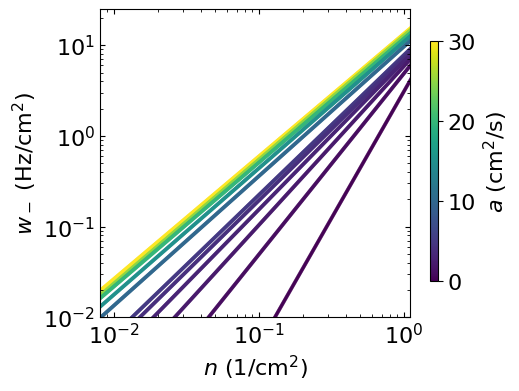

In [10]:
# cmap = 'Spectral_r'
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
xytext = (0.09, 10)
# x1lim=[5,10]
# x2lim=[50,350]
# x1lim = [8e-2, 1.1]  
# x1lim = [0.008, 11.0]
# x2lim = [0.01, 250.0]
x2lim = [1e-2, 25]
x1lim = [8e-3, 1.1]  
show_full_models=False

# x_values = np.linspace(0, 1, 1000)
x_values = np.logspace(-3, .4, 1000)


# figsize = (6, 4)  #(5,4)
# figsize = (3, 4) 
# figsize = (2.5, 4)  
figsize = (4, 4)  
fig, ax = plt.subplots(figsize=figsize)

# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))
# varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
varkappa_lst = list(reversed([#0, 
                              1, 2, 3, 4,
 5,
#  6,
#  7,
#  8,
#  9,
 10, 15, 20, 25, 30]))

# varkappa_set_values = sorted(df.varkappa.drop_duplicates())
# varkappa_lst = list(varkappa_set_values)

vmin = 0
# vmin = 0.01
vmax = 30  #np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot
    ax.scatter(x_values,
               y_values,
               c=c_values,
               cmap=cmap,
               alpha=0.6,
               s=3,
               vmin=vmin,
               vmax=vmax)

#annotate the auxiliary trial that could have taken more than twenty hours on the open science grid   
#heretim
M=3.1
nu=2.8
yhat_values=M*x_values**nu
ax.scatter(x_values,
           yhat_values,
           c=[0]*x_values.shape[0], # pure diffusion
           cmap=cmap,
           alpha=0.6,
           s=3,
           vmin=vmin,
           vmax=vmax)
    
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
#     x1label=r'$N/A$ (1/cm$^{2}$)',  #r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
#     x2label=    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #r'$w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
#     x1label=r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x1label=r'$n$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=r'$w_-$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')

if show_full_models:
    #plot the full models
    ax.scatter(fk['q'].values,
               fk['w'].values,
               c='C0',
               alpha=0.2,
               s=40,
               label='Fenton-Karma',
               zorder=0)
    ax.scatter(lr['q'].values,
               lr['w'].values,
               c='C1',
               alpha=0.2,
               s=40,
               label='Luo-Rudy',
               zorder=0)

plt.show()

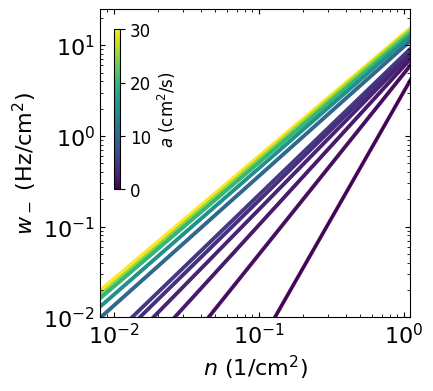

In [11]:
# cmap = 'Spectral_r'
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
xytext = (0.09, 10)
# x1lim=[5,10]
# x2lim=[50,350]
# x1lim = [8e-2, 1.1]  
# x1lim = [0.008, 11.0]
# x2lim = [0.01, 250.0]
x2lim = [1e-2, 25]
x1lim = [8e-3, 1.1]  
show_full_models=False

# x_values = np.linspace(0, 1, 1000)
x_values = np.logspace(-3, .4, 1000)


# figsize = (6, 4)  #(5,4)
# figsize = (3, 4) 
# figsize = (2.5, 4)  
figsize = (4, 4)  
fig, ax = plt.subplots(figsize=figsize)

# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))
# varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
varkappa_lst = list(reversed([#0, 
                              1, 2, 3, 4,
 5,
#  6,
#  7,
#  8,
#  9,
 10, 15, 20, 25, 30]))

# varkappa_set_values = sorted(df.varkappa.drop_duplicates())
# varkappa_lst = list(varkappa_set_values)

vmin = 0
# vmin = 0.01
vmax = 30  #np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot
    ax.scatter(x_values,
               y_values,
               c=c_values,
               cmap=cmap,
               alpha=0.6,
               s=3,
               vmin=vmin,
               vmax=vmax)

#annotate the auxiliary trial that could have taken more than twenty hours on the open science grid   
#heretim
M=3.1
nu=2.8
yhat_values=M*x_values**nu
ax.scatter(x_values,
           yhat_values,
           c=[0]*x_values.shape[0], # pure diffusion
           cmap=cmap,
           alpha=0.6,
           s=3,
           vmin=vmin,
           vmax=vmax)
    
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
#     x1label=r'$N/A$ (1/cm$^{2}$)',  #r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
#     x2label=    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #r'$w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
#     x1label=r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x1label=r'$n$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=r'$w_-$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
# cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cax = fig.add_axes([0.16, 0.43, 0.015, 0.4])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize-4)
cb.ax.tick_params(labelsize=fontsize-4)
ax.tick_params(top=True, right=True,direction='in',which='both')

if show_full_models:
    #plot the full models
    ax.scatter(fk['q'].values,
               fk['w'].values,
               c='C0',
               alpha=0.2,
               s=40,
               label='Fenton-Karma',
               zorder=0)
    ax.scatter(lr['q'].values,
               lr['w'].values,
               c='C1',
               alpha=0.2,
               s=40,
               label='Luo-Rudy',
               zorder=0)

plt.show()

In [12]:
saving=True
df_increasing_alinear_lst=[]
varkappa_lst=list(df['varkappa'].drop_duplicates().values)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    if query.any():
        M_returned = df.loc[query, 'M'].values
        nu_returned = df.loc[query, 'm'].values
        #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
        M = M_returned[0]
        nu = nu_returned[0]
        y_values = M * x_values**nu
        df_increasing_alinear_lst.append( df.loc[query].copy())

df_increasing_alinear = pd.concat(df_increasing_alinear_lst)
df_increasing_alinear['alinear'] = df_increasing_alinear['varkappa']
df_increasing_alinear['nu_minus'] = df_increasing_alinear['m']
df_increasing_alinear['M_minus'] = df_increasing_alinear['M']
df_increasing_alinear['Delta_nu_minus'] = df_increasing_alinear['Delta_m']
df_increasing_alinear['Delta_M_minus'] = df_increasing_alinear['Delta_M']

#save to pickle
if saving:
    df_death_rate_versus_alinear = df_increasing_alinear[['alinear','nu_minus','M_minus','Delta_nu_minus','Delta_M_minus']]
    dict_data = dict(df_death_rate_versus_alinear=df_death_rate_versus_alinear,
                     df_increasing_alinear=df_increasing_alinear)
    save_to_pickle(death_rate_versus_alinear_dir, dict_data)
    print(f"{death_rate_versus_alinear_dir=}")


death_rate_versus_alinear_dir='/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_tymura_increasing_alinear_run_36_FK.pkl'


In [13]:
#commented out parts of the plot ibid
# #plot arrow annotation
# ax.annotate("decreasing a", xy=(0.3, 11), xytext=xytext, fontsize=fontsize)
# ax.annotate(
#     "",
#     xy=(0.5, 0.08),
#     xytext=(0.15, 8),  #,zorder=-1e8,#zorder can send to back
#     arrowprops=dict(lw=3, headwidth=20., headlength=20., color='k',
#                     alpha=0.8))  #arrowstyle="->",

#TODO: add dashed-black line below a=0 with slope of exactly two
# #TODO: mark the slope of ^that line with ~2
# x1 = 0.09
# y1 = 2
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
# #DONE: mark the slope of ^that line with ~3
# x1 = 0.6
# y1 = 0.3
# annotation.slope_marker(origin=(x1, y1),
#                         slope=3,#(3, 1),
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
# # #DONE: test whether this slope is correct with a scatter plot of 2 points
# # x2 = 0.7
# # y2 = y1 * (x2 / x1)**3
# # ax.scatter([x1,x2],[y1,y2],marker='^',c='r',s=100,zorder=-1)
# # #DONT: if not, dev my own custom loglog slope plotter
# leg = ax.legend(loc='lower right', fontsize=fontsize - 6)
# for lh in leg.legendHandles:
#     lh.set_alpha(1)

In [14]:
varkappa_lst

[80.0,
 70.0,
 1.0,
 60.0,
 8.0,
 50.0,
 30.0,
 25.0,
 4.0,
 2.0,
 3.0,
 40.0,
 7.0,
 10.0,
 9.3,
 5.0,
 15.0,
 1.552,
 100.0,
 9.0,
 20.0,
 90.0,
 6.0,
 0.0]

## plot the exponents of the above powerlaw fits

In [15]:
# xytext = (0.09, 10)
# # x1lim=[5,10]
# # x2lim=[50,350]
# # x1lim = [8e-2, 1.1]  
# # x1lim = [0.008, 11.0]
# # x2lim = [0.01, 250.0]
# x2lim = [1e-2, 25]
# x1lim = [8e-3, 1.1]  
# show_full_models=False


In [16]:
df.loc[query]

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt


In [17]:
x_values = np.logspace(-3, .4, 1000)
varkappa_set_values = np.array(sorted(df.varkappa.drop_duplicates()))
varkappa_set_values = varkappa_set_values[varkappa_set_values>0].copy() #remove 0 for powerlaws
dict_graph_lst=[]
for varkappa in varkappa_set_values:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    D_returned = df.loc[query, 'D'].values
    for M,nu,D in zip(M_returned,nu_returned,D_returned):
        dict_graph_lst.append(dict(M=M,nu=nu,varkappa=varkappa,D=D))
df_graph = pd.DataFrame(dict_graph_lst)

In [18]:
varkappa_set_values,D_returned

(array([  1.   ,   1.552,   2.   ,   3.   ,   4.   ,   5.   ,   6.   ,
          7.   ,   8.   ,   9.   ,   9.3  ,  10.   ,  15.   ,  20.   ,
         25.   ,  30.   ,  40.   ,  50.   ,  60.   ,  70.   ,  80.   ,
         90.   , 100.   ]),
 array([0.115]))

In [19]:
#extract xy values
varkappa_values = df_graph['varkappa'].values
M_values = df_graph['M'].values
nu_values = df_graph['nu'].values
#fit powerlaw for M in terms of a
print(f"Powerlaw fit to magnitude:")
dict_fit = print_fit_power_law(x=varkappa_values,y=M_values)
print_dict(dict_fit)
MM = dict_fit['M']
Mnu = dict_fit['m']

Powerlaw fit to magnitude:
m = 0.305311 +/- 0.003264
M = 4.831914 +/- 0.112558 Hz/cm^2; B=174.071336 +/- 3.526465
RMSE=0.1827 Hz/cm^2; R^2=0.9994; MPE=1.3255%; N=23
rmse=0.18273508237220606
mpe=1.3255171507166528
Rsq=0.9993757499136605
num_obs=23
m=0.3053112327177798
Delta_m=0.0032636539886279564
M=4.83191407852063
Delta_M=0.11255821969141078
B=174.0713364068975
Delta_B=3.5264651299352825


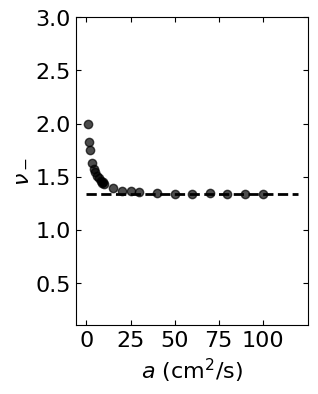

In [20]:
# cmap = 'Spectral_r'
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
figsize = (3, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

# df_graph.plot.scatter(ax=ax,x='varkappa',y='nu',c='varkappa',vmin=vmin,vmax=vmax,cmap='viridis')#,alpha=0.7,size=50)
ax.scatter(x=varkappa_values,y=nu_values,c='k',alpha=0.7)#,size=50)
# ax.scatter(x=varkappa_values,y=nu_values,c=varkappa_values,vmin=vmin,vmax=vmax,cmap='viridis')#,alpha=0.7,size=50)
# df_graph.plot(ax=ax,x='varkappa',y='nu')#,alpha=0.7,size=50)


#plot dotted line at 4/3
xv=np.linspace(0,120,10)
ax.plot(xv,0.*xv+4/3,'k--',lw=2)

ax.set_xticks([0,25,50,75,100])
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$\nu_-$',use_loglog=False,fontsize=fontsize)
# ax.set_xscale('log')
# fig.colorbar().remove() 
# ax.set_yscale('log')
# ax.get_legend().remove()
# cb = plt.colorbar() 
# cb.remove() 

ax.set_ylim([0.1,3])
plt.show()

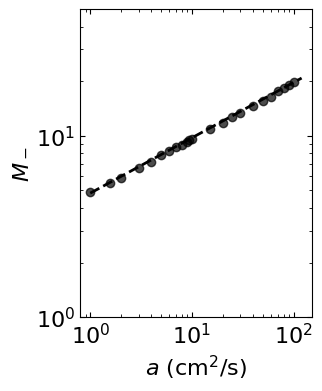

In [21]:
# cmap = 'Spectral_r'
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
figsize = (3, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

# df_graph.plot.scatter(ax=ax,x='varkappa',y='nu',c='varkappa',vmin=vmin,vmax=vmax,cmap='viridis')#,alpha=0.7,size=50)
ax.scatter(x=varkappa_values,y=M_values,c='k',alpha=0.7)#,size=50)
# ax.scatter(x=varkappa_values,y=nu_values,c=varkappa_values,vmin=vmin,vmax=vmax,cmap='viridis')#,alpha=0.7,size=50)
# df_graph.plot(ax=ax,x='varkappa',y='nu')#,alpha=0.7,size=50)


# #plot fit
xv=np.linspace(1,120,10)
ax.plot(xv,MM*xv**Mnu,'k--',lw=2)

ax.set_xticks([0,25,50,75,100])
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$M_-$',use_loglog=False,fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1,50])
plt.show()

# plot ^these two plots for either of the full models

In [22]:
#recall the xypoints for either full model
death_rate_versus_alinear_dir=f'{nb_dir}/data/full_results/data_fig4_tymura_increasing_alinear_run_36_FK.pkl'
assert os.path.exists(death_rate_versus_alinear_dir)
dict_data_fk=load_from_pickle(death_rate_versus_alinear_dir)
death_rate_versus_alinear_dir=f'{nb_dir}/data/full_results/data_fig4_tymura_increasing_alinear_run_36_LR.pkl'
assert os.path.exists(death_rate_versus_alinear_dir)
dict_data_lr=load_from_pickle(death_rate_versus_alinear_dir)

In [23]:
#choose x axis discretization
x_values = np.logspace(-3, .4, 1000)

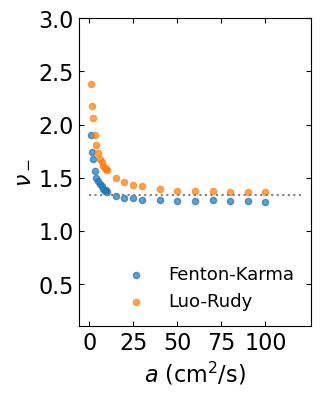

In [24]:
#plot the panel
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
figsize = (3, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#plot xy values for full models
dict_data_fk['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='nu_minus',ax=ax,c='C0',alpha=0.7,label='Fenton-Karma')
dict_data_lr['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='nu_minus',ax=ax,c='C1',alpha=0.7,label='Luo-Rudy')
#plot dotted line at 4/3
xv=np.linspace(0,120,10)
ax.plot(xv,0.*xv+4/3,':',color='gray')#,'k--',lw=2)
#format plot
format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$\nu_-$',use_loglog=False,fontsize=fontsize)
ax.set_xticks([0,25,50,75,100])
ax.tick_params(top=True, right=True,direction='in',which='both')

# AddLegend(ax=ax,xy=(0.1,0.990),fontsize=fontsize-3)
AddLegend(ax=ax,xy=(0.1,0.25),fontsize=fontsize-3)

ax.set_ylim([0.1,3])
plt.show()

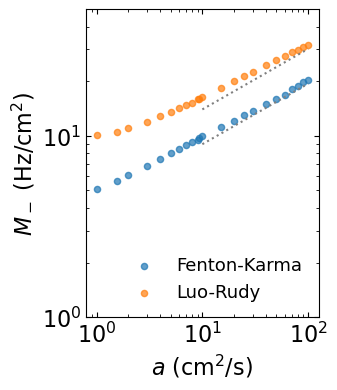

In [25]:
#plot the panel
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
figsize = (3, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#plot xy values for full models
dict_data_fk['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='M_minus',ax=ax,c='C0',alpha=0.7,label='Fenton-Karma')
dict_data_lr['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='M_minus',ax=ax,c='C1',alpha=0.7,label='Luo-Rudy')
#format plot
format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$M_-$ (Hz/cm$^2)$',use_loglog=False,fontsize=fontsize)
ax.set_xticks([0,25,50,75,100])
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_xscale('log')
ax.set_yscale('log')
# AddLegend(ax=ax,xy=(0.1,0.990),fontsize=fontsize-3)
AddLegend(ax=ax,xy=(0.1,0.25),fontsize=fontsize-3)
ax.set_ylim([1,50])

#####################
# plot the legend
#####################
#get 2 token points for either of the full models
#LR
num = 1/3 # 1.638 # ±0.017
# xlst=[0.14,0.8]
xlst=[1e1,1e2]
y1 = 9
y2 = y1 * (xlst[1]/xlst[0])**num
ylst=[y1,y2]
xlst_lr = list(xlst)
ylst_lr = list(ylst)

#FK
num = 1/3 # 1.88 # ±0.03
# xlst=[1.4,8]
# xlst=[7.,1e3]
y1 = 14
y2 = y1 * (xlst[1]/xlst[0])**num
ylst=[y1,y2]
xlst_fk = list(xlst)
ylst_fk = list(ylst)


#mark the slope corresponding to the FK model
ax.plot(xlst_fk,ylst_fk,':',color='gray')
#mark the slope corresponding to the LR model
ax.plot(xlst_lr,ylst_lr,':',color='gray')
#TOOD(in .odg): annotate slope marker as $nu_-$
plt.show()

In [26]:
#extrct xy vlues
alinear_fk = 1.552
alinear_lr = 9.3
dfdr = dict_data_fk['df_death_rate_versus_alinear']
alinear_vlues1 = dfdr[dfdr['alinear']!=alinear_fk]['alinear'].values
num_vlues1 = dfdr[dfdr['alinear']!=alinear_fk]['nu_minus'].values
Mm_vlues1 = dfdr[dfdr['alinear']!=alinear_fk]['M_minus'].values
num_fk = dfdr[dfdr['alinear']==alinear_fk]['nu_minus'].values
Mm_fk = dfdr[dfdr['alinear']==alinear_fk]['M_minus'].values

dfdr = dict_data_lr['df_death_rate_versus_alinear']
alinear_vlues2 = dfdr[dfdr['alinear']!=alinear_lr]['alinear'].values
num_vlues2 = dfdr[dfdr['alinear']!=alinear_lr]['nu_minus'].values
Mm_vlues2 = dfdr[dfdr['alinear']!=alinear_lr]['M_minus'].values
num_lr = dfdr[dfdr['alinear']==alinear_lr]['nu_minus'].values
Mm_lr = dfdr[dfdr['alinear']==alinear_lr]['M_minus'].values
num_lr

array([1.58548501])

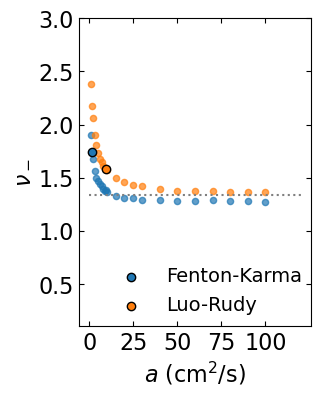

In [27]:
#plot the panel
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
figsize = (3, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#plot xy values for full models
dict_data_fk['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='nu_minus',ax=ax,c='C0',alpha=0.7)#,label='Fenton-Karma')
dict_data_lr['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='nu_minus',ax=ax,c='C1',alpha=0.7)#,label='Luo-Rudy')

ax.scatter([alinear_fk],[num_fk],marker='o',edgecolor='k',c='C0',#'k',
           alpha=1,label='Fenton-Karma')
ax.scatter([alinear_lr],[num_lr],marker='o',edgecolor='k',c='C1',#c='k',
           alpha=1,label='Luo-Rudy')

#plot dotted line at 4/3
xv=np.linspace(0,120,10)
ax.plot(xv,0.*xv+4/3,':',color='gray')#,'k--',lw=2)
#format plot
format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$\nu_-$',use_loglog=False,fontsize=fontsize)
ax.set_xticks([0,25,50,75,100])
ax.tick_params(top=True, right=True,direction='in',which='both')

# AddLegend(ax=ax,xy=(0.1,0.990),fontsize=fontsize-3)
# leg = AddLegend(ax=ax,xy=(0.1,0.25),fontsize=fontsize-3)
leg = AddLegend(ax=ax,xy=(0.065,0.25),fontsize=fontsize-2)
ax.set_ylim([0.1,3])
plt.show()

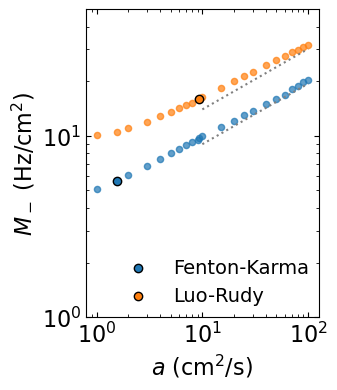

In [28]:
#plot the panel
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
figsize = (3, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#plot xy values for full models
dict_data_fk['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='M_minus',ax=ax,c='C0',alpha=0.7)#,label='Fenton-Karma')
dict_data_lr['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='M_minus',ax=ax,c='C1',alpha=0.7)#,label='Luo-Rudy')

ax.scatter([alinear_fk],[Mm_fk],marker='o',edgecolor='k',c='C0',#'k',
           alpha=1,label='Fenton-Karma')
ax.scatter([alinear_lr],[Mm_lr],marker='o',edgecolor='k',c='C1',#c='k',
           alpha=1,label='Luo-Rudy')


#format plot
format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$M_-$ (Hz/cm$^2)$',use_loglog=False,fontsize=fontsize)
ax.set_xticks([0,25,50,75,100])
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_xscale('log')
ax.set_yscale('log')
# AddLegend(ax=ax,xy=(0.1,0.990),fontsize=fontsize-3)
# leg = AddLegend(ax=ax,xy=(0.1,0.25),fontsize=fontsize-3)
leg = AddLegend(ax=ax,xy=(0.065,0.25),fontsize=fontsize-2)
ax.set_ylim([1,50])

#####################
# plot the legend
#####################
#get 2 token points for either of the full models
#LR
num = 1/3 # 1.638 # ±0.017
# xlst=[0.14,0.8]
xlst=[1e1,1e2]
y1 = 9
y2 = y1 * (xlst[1]/xlst[0])**num
ylst=[y1,y2]
xlst_lr = list(xlst)
ylst_lr = list(ylst)

#FK
num = 1/3 # 1.88 # ±0.03
# xlst=[1.4,8]
# xlst=[7.,1e3]
y1 = 14
y2 = y1 * (xlst[1]/xlst[0])**num
ylst=[y1,y2]
xlst_fk = list(xlst)
ylst_fk = list(ylst)


#mark the slope corresponding to the FK model
ax.plot(xlst_fk,ylst_fk,':',color='gray')
#mark the slope corresponding to the LR model
ax.plot(xlst_lr,ylst_lr,':',color='gray')
#TOOD(in .odg): annotate slope marker as $nu_-$
plt.show()

## goto generation of Figure 4 for the next/last two panels of figure 4
- TODO(later): move ^this to the .ipynb ibid and clean up this .ipynb

# DONE(later?): repeat ^this analysis for LR model

- GOAL: verify whether this works for both full models
- TODO(later): update the $\nu_-,M_-$ figures to have both full models

In [29]:
#MTT vs. a is in http://localhost:8891/notebooks/Generation%20of%20figure%204.ipynb

# generate updated rate plot of fits

In [30]:
#TODO: copy cells for existing panel
#TODO: make the two panels agree in terms of fontsize and axis limits.

# build minimum dataset from best fits cached for either of the full models at either of the length scales

In [24]:
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)

In [22]:
# df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
# df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
# df_defects_fk
# df_defects_fk

In [25]:
# latest_run_num=29
# run_num_lst = list(reversed(list(np.arange(14,latest_run_num+1))))
# # run_num_lst=[25,17]
# # run_num_lst=[25,19]
# # run_num_lst=[25,24]
# # run_num_lst = list(np.arange(12,26))
# # run_num_lst = list(np.arange(26,14))
# run_num_lst=[25,18]
# # run_num_lst=[28,18]
# run_num_lst=[28,29]
# # run_num_lst=[25,29]
# # run_num_lst=[32,29]
# run_num_lst=[32,29]
# #note 31==30...
run_num_lst=[28,29]  #what is in Particle_Paper?
# # run_num_lst=[32,33]  
# run_num_lst=[34,33]
# run_num_lst=[39,39]
# run_num_lst=[40,40]  #best fits to modified linear particle model
run_num_lst=[41,41]  #best fits to modified linear particle model

use_filterby_neighbor=False
# use_filterby_neighbor=True
neighbor=0
# neighbor=1

use_filterby_minN=True
use_filterby_minN=False
minN=9
minN=20
minN=50
# minN=70
# minN=90
# use_filterby_amax=True
use_filterby_amax=False
min_amax=1.

use_select_rxn=True
use_select_rxn=False
# r_trgt_lr=0.195
# kappa_trgt_lr=200
# r_trgt_fk=0.135
# kappa_trgt_fk=167.02
# kappa_trgt_fk=200
r_trgt_lr=0.155
kappa_trgt_lr=300
r_trgt_fk=0.135
kappa_trgt_fk=167.02

use_filterby_r=True
use_filterby_r=False
# rinf=0.195 #cm
# rinf=0.15 #cm
rinf=0.1 #cm
rsupa=0.5 #cm


# neighbor=1
remove_no_diffusion=True
use_filterby_D=False
Dinf=0.1 #cm^2/s
Dsupa=0.5 #cm^2/s
# Dinf=0
# Dinf=0.01
# run_num=25 #L=5 cm
# run_num=18 #L=10 cm
num_digits_round_amax=3
gmin_fk_lst=[]
gmin_lr_lst=[]
log_dir_fk_lst=[]
log_dir_lr_lst=[]
dict_results_fk_lst=[]
dict_results_lr_lst=[]
# for run_num in [25,18]: #chosen exemplar pair
for run_num in run_num_lst:
    parquet_dir_defects_fk=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_fk.parquet'
    parquet_dir_defects_lr=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_lr.parquet'
    input_folder=f'{nb_dir}/data/osg_output/run_{run_num}_all'
#     parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
#     parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
#     input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
    #load data
    df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
    df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
    
    #filterby neighbor
    if use_filterby_neighbor:
        df_defects_fk = df_defects_fk[df_defects_fk['neighbor']==neighbor].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['neighbor']==neighbor].copy()
    
    #compute order parameter for each member a=amax-2*D
    #add columns for amax
    df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
    df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)
    
    if remove_no_diffusion:
        df_defects_fk = df_defects_fk[df_defects_fk['D']>Dinf].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['D']>Dinf].copy()
        
        
    if use_filterby_D:
        df_defects_fk = df_defects_fk[df_defects_fk['D']<Dsupa].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['D']<Dsupa].copy()
        
    if use_filterby_r:
        df_defects_fk = df_defects_fk[(df_defects_fk['r']>=rinf)&(df_defects_fk['r']<rsupa)].copy()
        df_defects_lr = df_defects_lr[(df_defects_lr['r']>=rinf)&(df_defects_lr['r']<rsupa)].copy()
        
        
    if use_filterby_amax:
        df_defects_fk = df_defects_fk[df_defects_fk['amax']>min_amax].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['amax']>min_amax].copy()
        
    if use_select_rxn:
        df_defects_lr = df_defects_lr[
            (df_defects_lr['r']==r_trgt_lr)&
            (df_defects_lr['kappa']==kappa_trgt_lr)
        ].copy()
        df_defects_fk = df_defects_fk[
            (df_defects_fk['r']==r_trgt_fk)&
            (df_defects_fk['kappa']==kappa_trgt_fk)
        ].copy()
        # r_trgt_lr=0.155
        # kappa_trgt_lr=300
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Fenton-Karma Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    #supamax=40.
    supamax=1.8
    #supamax=40.
    for amax,g in df_defects_fk.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_fk=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    print(print_str)
    gmin_fk.sort_values(by='D',inplace=True)
    

    #find best simulation for the full model at this avalue
#     dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()].copy()
    dg_fk=gmin_fk[gmin_fk['log_likelihood'] == gmin_fk['log_likelihood'].max()].copy()
    dg_fk['run']=run_num
    df_defects_fk['run']=run_num
    dg_fk['model']='Fenton-Karma'
    cluster_index,job_index = dg_fk[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_fk=input_fn
        df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_fk=dg_fk['amax'].median()
        rmse_fk=dg_fk['rmse'].median()
        L = dg_fk['L'].median()
        print(f"\nbest fit for Fenton-Karma: RMSE: {rmse_fk:.4f} Hz/cm^2, amax: {amax_fk:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_fk=}")
        #record
        dict_results_fk=dict(
            model_name='Fenton-Karma',
            amax=amax_fk,
            rmse=rmse_fk,
            L=L,
            df_fit=df_fit_fk,
            dg_fit=dg_fk,
            dict_linear_fit=dict_linear_fit_fk,
            filename=input_fn_fk,
            gmin=gmin_fk)
        dict_results_fk_lst.append(dict_results_fk)
        gmin_fk_lst.append(gmin_fk)
        log_dir_fk_lst.append(input_fn)
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Luo-Rudy Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    #supamax=40
    supamax=10.2
    infamax=10
    #print_str=None
    for amax,g in df_defects_lr.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        #if (rmse_min<=minrmse)&(amax<=supamax):
        if (rmse_min<=minrmse)&(amax<=supamax)&(amax>infamax):
            minrmse=rmse_min
            gmin_lr=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    print(print_str)        
    gmin_lr.sort_values(by='D',inplace=True)
    
    #find best simulation for the full model at this avalue
#     dg_lr=gmin_lr[gmin_lr['rmse'] == gmin_lr['rmse'].min()].copy()
    dg_lr=gmin_lr[gmin_lr['log_likelihood'] == gmin_lr['log_likelihood'].max()].copy()
    dg_lr['run']=run_num
    df_defects_lr['run']=run_num
    dg_lr['model']='Luo-Rudy'
    cluster_index,job_index = dg_lr[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_lr=input_fn
        df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_lr=dg_lr['amax'].median()
        rmse_lr=dg_lr['rmse'].median()
        L = dg_lr['L'].median()
        print(f"\nbest fit for Luo-Rudy: RMSE: {rmse_lr:.4f} Hz/cm^2, amax: {amax_lr:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_lr=}")
        #record
        dict_results_lr=dict(
            model_name='Luo-Rudy',
            amax=amax_lr,
            rmse=rmse_lr,
            L=L,
            df_fit=df_fit_lr,
            dg_fit=dg_lr,
            dict_linear_fit=dict_linear_fit_lr,
            filename=input_fn_lr,
            gmin=gmin_lr)
        dict_results_lr_lst.append(dict_results_lr)
        gmin_lr_lst.append(gmin_lr)
        log_dir_lr_lst.append(input_fn)

    #print(f"\nparameter range supported in run #{run_num}:")
    print(f"number of trials: {df_defects_lr.shape[0]}")
    #print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L','neighbor']].T[['min','max']].T)


**************************************
* Fenton-Karma Model (best settings):
**************************************
amax=1.7820, rmse_min=0.6815, log_likelihood=-53.1388, count=357

best fit for Fenton-Karma: RMSE: 8.5740 Hz/cm^2, amax: 1.7820 cm^2/s, L: 5.0 cm
input_fn_fk='/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_41_all/job.out.30675934.592'

**************************************
* Luo-Rudy Model (best settings):
**************************************
amax=10.1400, rmse_min=5.0043, log_likelihood=-38.8959, count=400

best fit for Luo-Rudy: RMSE: 52.7748 Hz/cm^2, amax: 10.1400 cm^2/s, L: 5.0 cm
input_fn_lr='/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_41_all/job.out.30675934.374'
number of trials: 757

**************************************
* Fenton-Karma Model (best settings):
**************************************
amax=1.7820, rmse_min=0.6815, log_likelihood=-53.1388, count=357

best fit for Fenton-Karma: RMSE: 8.5740 Hz/cm^2, ama

In [40]:
# df_defects_fk

# compute the powerlaw exponents to the full model annihilation rate densities

In [26]:
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk']
lr=dict_wjr['lr']

In [27]:
print(f"annihilation rate density powerlaw fits:")
dict_fit_death_fk = print_fit_power_law(x=fk['q'].values,y=fk['w'].values)
dict_fit_death_lr = print_fit_power_law(x=lr['q'].values,y=lr['w'].values)


annihilation rate density powerlaw fits:
m = 1.877234 +/- 0.024488
M = 5.572316 +/- 0.299027 Hz/cm^2; B=2.496963 +/- 0.039522
RMSE=0.1386 Hz/cm^2; R^2=0.9969; MPE=6.9910%; N=73
m = 1.637556 +/- 0.016847
M = 16.735599 +/- 0.829136 Hz/cm^2; B=5.587740 +/- 0.065801
RMSE=0.1340 Hz/cm^2; R^2=0.9973; MPE=7.2488%; N=100


# Plot mean annihilation rates

In [28]:
#get 2 token points for either of the full models
#LR
num = 1.638 # ±0.017
# xlst=[0.14,0.8]
xlst=[0.18,0.96]
y1 = 4
y2 = y1 * (xlst[1]/xlst[0])**num
ylst=[y1,y2]
xlst_lr = list(xlst)
ylst_lr = list(ylst)

#FK
num = 1.88 # ±0.03
# xlst=[1.4,8]
xlst=[1.3,7.]
y1 = 2
y2 = y1 * (xlst[1]/xlst[0])**num
ylst=[y1,y2]
xlst_fk = list(xlst)
ylst_fk = list(ylst)

In [29]:
sfk=0.1
slr=0.1



In [36]:
slr=0.3**2/(9.3+2*0.42)/4
sfk=0.66**2/(1.552+2*0.115)/4

In [38]:
slr=0
sfk=0

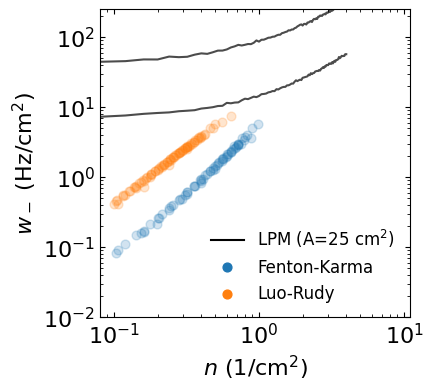

run_num_lst=[41, 41]
neighbor=0


In [39]:
# use_filterby_minN=True
use_filterby_minN=False
minN=10
# minN=8
# figsize = (6, 4)  #(5,4)
figsize = (4, 4)  #(5,4)
fontsize=16

# x1lim=[0.008, 11]
x1lim=[0.08, 11]
x2lim=[0.01, 250]


fig, ax = plt.subplots(figsize=figsize)
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,x1lim=x1lim, x2lim=x2lim)

# Linear Particle (L=5)
df_fit_fk = dict_results_fk_lst[0]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[0]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[0]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[0]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

df_fit_fk['ww']=df_fit_fk['w']/(1+sfk*df_fit_fk['w'])
df_fit_lr['ww']=df_fit_lr['w']/(1+slr*df_fit_lr['w'])
df_fit_fk.plot(x='q',y='ww',alpha=0.7,ax=ax,color='k',label=r'LPM (A=25 cm$^2$)')#r'Lin. (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
df_fit_lr.plot(x='q',y='ww',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=r'LPM (A=25 cm$^2$)')#r'Lin. (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
# df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=r'Particle (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=r'Linear Particle (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
# df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')

# Linear Particle (L=10)
df_fit_fk = dict_results_fk_lst[1]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[1]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[1]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[1]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

show_A100=False
if show_A100:
    df_fit_fk['ww']=df_fit_fk['w']/(1+sfk*df_fit_fk['w'])
    df_fit_lr['ww']=df_fit_lr['w']/(1+slr*df_fit_lr['w'])
    df_fit_fk.plot(x='q',y='ww',alpha=0.7,ax=ax,color='r',label=r'LPM (A=100 cm$^2$)')#r'Lin (A=100 cm$^2$)')#f'Lin. Particle (L=5)')
    df_fit_lr.plot(x='q',y='ww',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'LPM (A=100 cm$^2$)')#r'Lin (A=100 cm$^2$)')#f'Lin. Particle (L=5)')
# df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Linear Particle (A=100 cm$^2$)')#)f'Lin. Particle (L=10)')
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=f'Linear Particle (L=10)')#,label='_Best Fit to FK')
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Lin. Particle (A=100 cm$^2$)')#)f'Lin. Particle (L=10)')
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Particle (A=100 cm$^2$)')#)f'Lin. Particle (L=10)')
# df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')

# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$n$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# format_plot(ax=ax,xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
# leg = ax.legend(loc='upper left',fontsize=fontsize-3.,frameon=False,ncol=1)
# leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
leg = ax.legend(loc='lower right',fontsize=fontsize-4.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# ax.get_legend().remove()


# #mark the slope corresponding to the FK model
# ax.plot(xlst_fk,ylst_fk,':',color='gray')
# #mark the slope corresponding to the LR model
# ax.plot(xlst_lr,ylst_lr,':',color='gray')
# #TOOD(in .odg): annotate slope marker as $nu_-$

# x1lim = [8e-3, 1.1]  
# x2lim = [1e-2, 25]
# ax.set_xlim(x1lim)
# ax.set_ylim(x2lim)

#add annotation
# xytext=(0.09, 10)
# xytext=(0.01, 90)
# ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
# .tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False,
#                      bottom=False, top=True, left=False, right=False)
# xytext=(0.01, 40)
# xy=(0.3, 11)
# ax.annotate(r"$a_{max}$ = const.", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observed", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observation"+f"\nfrom MSR of full", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# #add marker showing the slope of ~2
# annotation.slope_marker(origin=(.75, 2.0),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},
#                         ax=ax)
plt.show()
print(f"{run_num_lst=}")
print(f"{neighbor=}")

$\nu_-$

In [40]:
dh_lst=[]
col_lst=['model','amax','L','varkappa','D','r','kappa',
           'rmse','log_likelihood','neighbor','mpe',
           'q_lo', 'q_hi','CollTime_lo', 'CollTime_hi','N_lo', 'N_hi',
          'run','cluster_index', 'job_index']

for dict_results_fk in dict_results_fk_lst:
    dg_fit_fk = dict_results_fk['dg_fit']
    dh_lst.append(dg_fit_fk[col_lst])
    #dg_fit_fk = dict_results_fk['dg_fit']
    #dh_lst.append(dg_fit_fk[col_lst])

for dict_results_lr in dict_results_lr_lst:
    dg_fit_lr = dict_results_lr['dg_fit']
    dh_lst.append(dg_fit_lr[col_lst])
    #dg_fit_lr = dict_results_lr['dg_fit']
    #dh_lst.append(dg_fit_lr[col_lst])
df_annihil_fits = pd.concat(dh_lst)
# df_annihil_fits.rese`t_index(inplace=True)
df_annihil_fits.sort_values(by=['model','L'],inplace=True)
df_annihil_fits

,model,amax,L,varkappa,D,r,kappa,rmse,log_likelihood,neighbor,mpe,q_lo,q_hi,CollTime_lo,CollTime_hi,N_lo,N_hi,run,cluster_index,job_index
222,Fenton-Karma,1.782,5.0,1.552,0.115,0.457,5.0,8.574020,-53.138845,0.0,1793.194629,0.08,4.0,0.000702,0.005501,2.0,100.0,41,30675934,592
222,Fenton-Karma,1.782,5.0,1.552,0.115,0.457,5.0,8.574020,-53.138845,0.0,1793.194629,0.08,4.0,0.000702,0.005501,2.0,100.0,41,30675934,592
536,Luo-Rudy,10.140,5.0,9.300,0.420,0.314,60.0,52.774754,-38.895853,0.0,3404.577965,0.08,4.0,0.000123,0.000902,2.0,100.0,41,30675934,374
536,Luo-Rudy,10.140,5.0,9.300,0.420,0.314,60.0,52.774754,-38.895853,0.0,3404.577965,0.08,4.0,0.000123,0.000902,2.0,100.0,41,30675934,374


In [46]:
# NOTE: if i can get r,kappa at L=10 to match r,kappa from L=5, then I can greatly shrink/simplify Table 1.
#DONE: constrain LR model to have D<0.5 for L=10

In [47]:
# annihil_fits_dir = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.{run_num_lst[0]}.{run_num_lst[1]}.csv'
# annihil_fits_dir = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.'
annihil_fits_dir = f'{nb_dir}/data/annihil_fits.'
for run_num in run_num_lst:
    annihil_fits_dir += f"{run_num}."
annihil_fits_dir+='csv'
print(f"{annihil_fits_dir=}")
#save as .csv and send to WJ right now!
# annihil_fits_dir = '/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.csv'
df_annihil_fits.to_csv(annihil_fits_dir,index=False)
print(df_annihil_fits)

annihil_fits_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.28.29.csv'
              model    amax     L  varkappa     D      r  kappa      rmse  \
10845  Fenton-Karma   1.780   5.0     1.080  0.35  0.045  750.0  0.053314   
1282   Fenton-Karma   1.780  10.0     1.080  0.35  0.075  500.0  0.060097   
6862       Luo-Rudy  10.147   5.0     7.347  1.40  0.055  300.0  0.223516   
2890       Luo-Rudy  10.147  10.0     7.647  1.25  0.180  250.0  0.115310   

       log_likelihood  neighbor       mpe  q_lo  q_hi  CollTime_lo  \
10845       40.844481       0.0  1.695318  0.32  3.92     0.000716   
1282       138.099510       0.0  3.128476  0.08  0.98     0.001871   
6862        16.688338       0.0  2.988096  0.32  3.92     0.000525   
2890       112.183737       0.0  2.781997  0.08  0.98     0.000634   

       CollTime_hi  N_lo   N_hi  run  cluster_index  job_index  
10845     0.063201  10.0  100.0   28       23387298       6007  
1282      0.252627  10.0  100.0   29  

In [48]:
print(f"Table of maximum likelihood fits of linear particle model to full models.")
# print(df_annihil_fits[['model','amax','L','rmse']])
print(df_annihil_fits[['model','amax','L','mpe']])

Table of maximum likelihood fits of linear particle model to full models.
              model    amax     L       mpe
10845  Fenton-Karma   1.780   5.0  1.695318
1282   Fenton-Karma   1.780  10.0  3.128476
6862       Luo-Rudy  10.147   5.0  2.988096
2890       Luo-Rudy  10.147  10.0  2.781997


In [49]:
print(f"Table of maximum likelihood fits of linear particle model to full models.")
print(df_annihil_fits[['model','amax','mpe','L','D','varkappa','r','kappa','neighbor']].T)

Table of maximum likelihood fits of linear particle model to full models.
                 10845         1282      6862      2890 
model     Fenton-Karma  Fenton-Karma  Luo-Rudy  Luo-Rudy
amax              1.78          1.78    10.147    10.147
mpe           1.695318      3.128476  2.988096  2.781997
L                  5.0          10.0       5.0      10.0
D                 0.35          0.35       1.4      1.25
varkappa          1.08          1.08     7.347     7.647
r                0.045         0.075     0.055      0.18
kappa            750.0         500.0     300.0     250.0
neighbor           0.0           0.0       0.0       0.0


In [50]:
print(f"Table of maximum likelihood fits of linear particle model to full models.")
# print(df_annihil_fits[['model','amax','L','rmse']])
print(df_annihil_fits[['model','amax','L','mpe']])

Table of maximum likelihood fits of linear particle model to full models.
              model    amax     L       mpe
10845  Fenton-Karma   1.780   5.0  1.695318
1282   Fenton-Karma   1.780  10.0  3.128476
6862       Luo-Rudy  10.147   5.0  2.988096
2890       Luo-Rudy  10.147  10.0  2.781997


In [51]:
#GOAL: compute mean percent error for table 1 instead of RMSE
#DONE: modify generation of df_defects_fk,lr to compute mean percent error where RMSE is computed
#DONE: compute MPE for annihilations
#DONE: compute MPE for msr
#DONE: modify print_fit_power_law to also print mean percent error

In [52]:
dfk = pd.concat([x['df_fit'][['N','L','CollTime','q','w']] for x in dict_results_fk_lst])
dfk['model_name']='Fenton-Karma'
dlr = pd.concat([x['df_fit'][['N','L','CollTime','q','w']] for x in dict_results_lr_lst])
dlr['model_name']='Luo-Rudy'
d=pd.concat([dfk,dlr])
directory = annihil_fits_dir.replace('fits','fitted_values')
d.reset_index().to_csv(directory)
directory

'/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fitted_values.28.29.csv'

## estimate the root-mean-squared range between particles in the linear particle model

- TODO: estimate $R_\text{rms}$ for the linear model's fit to the full models
 - $R_\text{rms} = \mathbb{E}_\Gamma \Big[\text{MSR}(t')\Big],\quad \text{MSR}(t')=\mathbb{E}_i \Big[R_{i}^2(t')\Big]. $
 - TODO: compare to $R_\text{rms}$ for both of the full models. do any of the estimates agree?

for the linear particle model, the mean squared distance between particles can be estimated:

$R_\text{rms, Lin.} = \mathbb{E}_\Gamma \Big[\mathbb{E}_i \big[R_{i}^2(t')\big]\Big]=\int_0^\infty \Big(\frac{dt'}{\Gamma} e^{-t'/\Gamma}\Big)4at'=4a\Gamma$

recall the mean minimum lifetimes:
 - FK: mean lifetime: 105.3196 +/- 1.6729 ms (N=36179, p_normal: 0.2736) from 80 termination events
 - LR: mean lifetime: 33.3659 +/- 0.7163 ms (N=15273, p_normal: 0.9936) from 595 termination events

In [298]:
dict_Gamma={
    'Fenton-Karma': 0.1053196, #+/- 0.0007163 seconds
    'Luo-Rudy': 0.0333659, #+/- 0.0016729 seconds
}
dict_Delta_Gamma={
    'Fenton-Karma': 0.0007163, # seconds
    'Luo-Rudy': 0.0016729 # seconds
}

In [295]:
for n,g in df_annihil_fits.iterrows():
    mod = g.model
    Gamma = dict_Gamma[mod]
    R_rms = 4.*g['amax']*Gamma
    L=g['L']
    print(f"{mod} ({L=} cm):\t\t{R_rms=:.4f} cm")

Fenton-Karma (L=5.0 cm):		R_rms=0.7503 cm
Fenton-Karma (L=10.0 cm):		R_rms=0.7503 cm
Luo-Rudy (L=5.0 cm):		R_rms=1.3543 cm
Luo-Rudy (L=10.0 cm):		R_rms=1.3543 cm


In [299]:
#TODO: estimate 95% CI using Delta_Gamma
for n,g in df_annihil_fits.iterrows():
    mod = g.model
    Gamma = dict_Gamma[mod]
    Delta_Gamma = dict_Delta_Gamma[mod]
    R_rms = 4.*g['amax']*Gamma
    R_rms_hi = 4.*g['amax']*(Gamma+Delta_Gamma)
    R_rms_lo = 4.*g['amax']*(Gamma-Delta_Gamma)
    Delta_R_rms = np.max([R_rms_hi-R_rms,R_rms-R_rms_lo])
    
    L=g['L']
    print(f"{mod} ({L=} cm):\t\t{R_rms=:.4f} +/- {Delta_R_rms:.4f} cm")

Fenton-Karma (L=5.0 cm):		R_rms=0.7503 +/- 0.0051 cm
Fenton-Karma (L=10.0 cm):		R_rms=0.7503 +/- 0.0051 cm
Luo-Rudy (L=5.0 cm):		R_rms=1.3543 +/- 0.0679 cm
Luo-Rudy (L=10.0 cm):		R_rms=1.3543 +/- 0.0679 cm


In [300]:
# df_annihil_fits

In [29]:
nb_dir

'/Users/timothytyree/Documents/GitHub/bgmc/python'

# plot the birth rates separate

In [42]:
birth_rate_dir_fk = f'{nb_dir}/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = f'{nb_dir}/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# birth_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

In [251]:
wjr=recall_powerlaw_fits_to_full_models()


In [252]:
# DONE: compute powerlaw fits of birth rates wjr
print(f"creation rate density powerlaw fits:")
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nannihilation rate density powerlaw fits:")
print(f"wjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

creation rate density powerlaw fits:
m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; MPE=3.0209%; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; MPE=4.2323%; N=62

annihilation rate density powerlaw fits:
wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


In [253]:
xv = np.arange(0.1, 1,0.01)
# evaluate powerlaw fits of birth rates wjr
yv_birth_lr = dict_fit_birth_lr['M']*xv**dict_fit_birth_lr['m']
# yv_death_lr = wjr['lr_pbc']['M']*xv**wjr['lr_pbc']['m']
# evalutate plot powerlaw fits of death rates wjr
yv_birth_fk = dict_fit_birth_fk['M']*xv**dict_fit_birth_fk['m']
# yv_death_fk = wjr['fk_pbc']['M']*xv**wjr['fk_pbc']['m']
# yv_birth_lr.shape,yv_birth_fk.shape

# #compute the intersection point for both of the full models
# index_fk = np.argmin(np.exp(np.log(yv_birth_fk/yv_death_fk)**2))
# qstar_fk = xv[index_fk]
# wstar_fk = yv_birth_fk[index_fk]
# # index_lr = np.argmin(np.log(yv_birth_lr/yv_death_lr)**2)
# index_lr = np.argmin(np.exp(np.log(yv_birth_lr/yv_death_lr)**2))
# qstar_lr = xv[index_lr]
# wstar_lr = yv_birth_lr[index_lr]
# qstar_lr

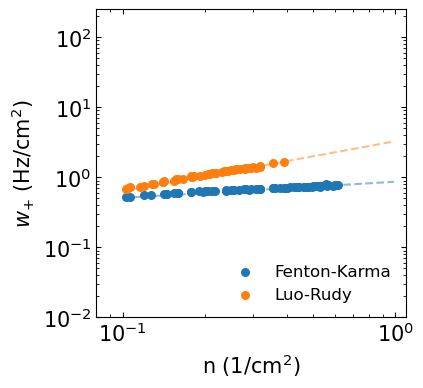

In [254]:
# fig,ax=plt.subplots()
# figsize = (6, 4)  #(5,4)
figsize = (4,4)
# fontsize=16
fig,ax=plt.subplots(figsize=figsize)
fontsize=15
# x1lim=[0.008, 11]
# x1lim=[0.08, 11]
# x2lim=[0.01, 250]
legend_alpha=1.0
minx=0.1
alpha=0.2
s=40
# fontsize=18
use_loglog=True
frameon_legend=False
show_fk=True
show_lr=True
zorder=0
# df_birth_fk.plot(x='q',y='w',ax=ax,c='C0',alpha=0.5,label=r'FK: N$\rightarrow$N+2',lw=4)
# fk.plot(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',lw=4)
# df_birth_lr.plot(x='q',y='w',ax=ax,c='C1',alpha=0.5,label=r'LR: N$\rightarrow$N+2',lw=4)
# lr.plot(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',lw=4)
markersize=30

# df_birth_fk.plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
df_birth_fk[df_birth_fk['q']>minx].plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
#                          marker='^',label=r'FK: N$\rightarrow$N+2',
                         label=r'Fenton-Karma',
                         alpha=1.,s=markersize)
# fk.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
# df_birth_lr.plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
df_birth_lr[df_birth_lr['q']>minx].plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
#                         marker='^',label=r'LR: N$\rightarrow$N+2',
                         label=r'Luo-Rudy',
                         alpha=1.,s=markersize)
# lr.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)

#plot the powerlaw fits
# ax.plot(xv,yv_death_fk,'k--',alpha=0.5)
# ax.plot(xv,yv_death_lr,'k--',alpha=0.5)
# ax.plot(xv,yv_birth_fk,'k--',alpha=0.5)
# ax.plot(xv,yv_birth_lr,'k--',alpha=0.5)
ax.plot(xv,yv_birth_fk,'C0--',alpha=0.5)
ax.plot(xv,yv_birth_lr,'C1--',alpha=0.5)

# #draw vertical dotted line up to the intersection point for both of the full models
# ax.scatter([qstar_fk],[wstar_fk],c='k',s=40,alpha=0.9,zorder=100)
# ax.scatter([qstar_lr],[wstar_lr],c='k',s=40,alpha=0.9,zorder=100)
# ax.plot([qstar_fk,qstar_fk],[0.001,wstar_fk],'k:',alpha=0.9)
# ax.plot([qstar_lr,qstar_lr],[0.001,wstar_lr],'k:',alpha=0.9)

ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$n$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# format_plot(ax=ax,xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
leg = ax.legend(loc='upper left',fontsize=fontsize-3.,frameon=False,ncol=1)
# leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

    
    
# format_plot
format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'$w_{+}$ (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# # plt.legend(fontsize=14,frameon=False,loc='upper left')
# plt.legend(fontsize=14,frameon=False,loc='upper left')
# # ax.get_legend().remove()


leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# ax.get_legend().remove()

# AddLegend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((0.0023641776732192935, 25.08908114695242))
ax.tick_params(top=True, right=True,direction='in',which='both')
# ax.set_xlim((0.008, 11.0))
# ax.set_ylim((0.01, 250.0))
# ax.set_xlim(x1lim)
ax.set_xlim([0.08, 1.1])
ax.set_ylim(x2lim)
plt.show()

In [255]:
x1lim

[0.08, 11]

# compute the exponents of the above powerlaw fits

In [269]:
#heretim
minN=10
use_filterby_minN=True
qmax=1.
use_filterby_maxq=False
print(f"fitting annihilation rate density of linear to powerlaws:")
print(f"{use_filterby_minN=}, {minN=}")
print(f"{use_filterby_maxq=}, {qmax=} per cm^2")

# Linear Particle (L=5)
df_fit_fk = dict_results_fk_lst[0]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[0]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[0]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[0]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

if use_filterby_maxq:
    df_fit_fk = df_fit_fk[df_fit_fk['q']<=qmax].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['q']<=qmax].copy()   
    
L=5
print(f"\nFK model ({L=}):")
print_fit_power_law(df_fit_fk['q'].values,df_fit_fk['w'].values)
print(f"\nLR model ({L=}):")
print_fit_power_law(df_fit_lr['q'].values,df_fit_lr['w'].values)

# Linear Particle (L=10)
df_fit_fk = dict_results_fk_lst[1]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[1]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[1]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[1]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()
if use_filterby_maxq:
    df_fit_fk = df_fit_fk[df_fit_fk['q']<=qmax].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['q']<=qmax].copy()   
    
L=10
print(f"\nFK model ({L=}):")
print_fit_power_law(df_fit_fk['q'].values,df_fit_fk['w'].values)
print(f"\nLR model ({L=}):")
print_fit_power_law(df_fit_lr['q'].values,df_fit_lr['w'].values);

fitting annihilation rate density of linear to powerlaws:
use_filterby_minN=True, minN=10
use_filterby_maxq=False, qmax=1.0 per cm^2

FK model (L=5):
m = 1.885151 +/- 0.009534
M = 5.524906 +/- 0.109406 Hz/cm^2; B=2.476137 +/- 0.014370
RMSE=0.8230 Hz/cm^2; R^2=0.9994; MPE=2.3090%; N=91

LR model (L=5):
m = 1.661909 +/- 0.008920
M = 18.943426 +/- 0.546434 Hz/cm^2; B=5.870423 +/- 0.044610
RMSE=2.6148 Hz/cm^2; R^2=0.9993; MPE=2.1603%; N=91

FK model (L=10):
m = 1.891692 +/- 0.019329
M = 5.362795 +/- 0.177817 Hz/cm^2; B=2.429831 +/- 0.019736
RMSE=0.1121 Hz/cm^2; R^2=0.9976; MPE=6.7992%; N=91

LR model (L=10):
m = 1.617477 +/- 0.014232
M = 15.415717 +/- 0.576912 Hz/cm^2; B=5.425689 +/- 0.042303
RMSE=0.2546 Hz/cm^2; R^2=0.9982; MPE=4.3113%; N=91


In [262]:
# Q: does setting L=5 to use the same parameters as L=10 improve the exponent at high density?
# A: Yes. let's keep it.
# LR model (L=5):
# m = 1.520112 +/- 0.008772

In [155]:
print(f"expected exponents for FK: 1.88 ± 0.03")
print(f"\nexpected exponents for LR: 1.638±0.017")

expected exponents for FK: 1.88 ± 0.03

expected exponents for LR: 1.638±0.017


compare to incumbent exponent row: <br>
$\nu_-:$ 1.638±0.017 1.613±0.014 1.62±0.03 1.88 ± 0.03 1.80±0.02 1.92±0.06

# Generation of figure 3
Tim Tyree<br>
1.3.2022

In [126]:
#TODO(later): remake these plots with any a,D,r,kappa combination inside the bounds of the result of my >500 years of computation time
#HINT: interp=recall_particle_model_interp()  #estimated run time ~20 seconds
# comp_mse_via_interp_unattractive
# import cudf

In [52]:
# #recall the fit of the particle model to the powerlaw fits from the full models
# wjr=recall_powerlaw_fits_to_full_models()
# print(*wjr)

In [53]:
# # recall_particle_parameter_fits 
# a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
# a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
# a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

# generate plot of powerlaw annihilation rates from the linear particle model
- DONE: directly compute the powerlaws from the particle model with vector-summed inverse powerlaw attraction
- Nota Bene: this process is automated by my pythonic function recall_particle_model_interp from lib

In [179]:
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_18_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
input_fn=f"{nb_dir}/data/osg_output/run_15_all_powerlaw_fits.csv" #works for many parameter settings (L=10)
df=pd.read_csv(input_fn)
df.head()

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt
0,4.231491,0.160727,93.361321,36.833594,0.996631,0.523422,3.733662,lr_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
1,1.990970,0.063111,25.768610,4.887806,0.997652,0.268464,1.689743,lr_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
2,2.096149,0.062995,29.023787,5.132623,0.997889,0.201797,2.107838,lr_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
3,2.938888,0.073003,16.435418,2.756748,0.998556,0.101718,0.770270,fk_ncbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4,2.353145,0.071580,7.303514,1.181615,0.997837,0.068909,0.134410,fk_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001


In [12]:
r=0.1
kappa=500#250
D=0.7
# varkappa_lst=sorted(set(df['varkappa'].values))
# varkappa_lst

#TODO: extract xy values for kappa, r, D fixed to any value, which I can change later
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10

#template query for the DataFrame
query =(df.set_second==set_second)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
query&=df.r==r
query&=df.kappa==kappa
query&=df.D==D
query&=df.L==L
# query&=df.x0==x0
query_template=query.copy()

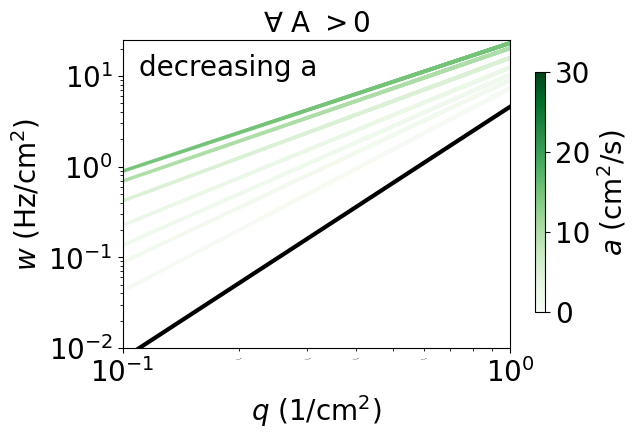

In [13]:
num_points = 25
c_col = 'rmse_full'
vmin = 0.
vmax = .25
fontsize = 20
x1lim = [1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
fig, ax = plt.subplots(figsize=(5,4))
varkappa_lst = sorted(set(df['varkappa'].values))
varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))

vmin = 0
vmax = np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled
    M = M_returned[0]
    nu = nu_returned[0]
    x_values = np.linspace(0, 1, 1000)
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values

    #scatter plot
    if varkappa==0:
        ax.plot(x_values,y_values,c='black',alpha=1.,lw=3)#,s=5)
        first_case=False
    else:
        ax.scatter(x_values,y_values,
               c=c_values,cmap='Greens',alpha=0.7,s=3,vmin=vmin,vmax=2*vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(ax,
           x1lim=x1lim,
           x2lim=x2lim,
           x1label=r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
           x2label=r'$w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
           title=None,
           fontsize=fontsize,
           use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)

import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.Greens
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

ax.annotate("decreasing a", xy=(0.3, 11), xytext=(0.11, 10),fontsize=fontsize)
ax.set_title(r'$\forall $ A $ > 0$',fontsize=fontsize)
# ax.set_title(r'For all A $ > 0$',fontsize=fontsize)
plt.show()

__dependence of M on a__

src 'generate figure effect of increasing a.ipynb':
- for D=0.7, kappa=250, r=0.1 fixed,
- the powerlaw OLS fit for loglog of M versus a
- m=0.34662844685683697
- Delta_m=0.007544034420649642
- b=1.5430792099954873
- Delta_b=0.023831286783598894
- Rsquared=0.9972947153026107

#  DONE: generate Fig. 2C individually

In [134]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A']*10**3 #Hz/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A']*10**3 #Hz/cm^2

In [135]:
#DONT: dev PlotScatter function for the full models
#input: ax, df=lr or fk, c='C0' or 'C1'
#output: True and plotted values
#reset matplotlib
mpl.rcParams.update(matplotlib.rcParamsDefault)


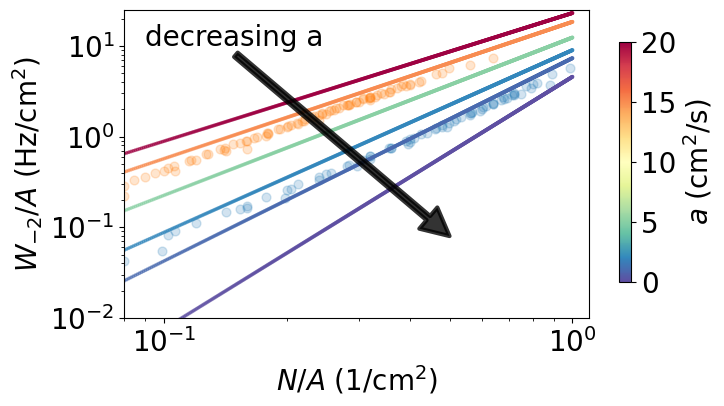

In [136]:
cmap = 'Spectral' + '_r'
num_points = 25
c_col = 'rmse_full'
fontsize = 20
xytext = (0.09, 10)
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))

vmin = 0
vmax = 20  #np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    x_values = np.linspace(0, 1, 1000)
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot
    ax.scatter(x_values,
               y_values,
               c=c_values,
               cmap=cmap,
               alpha=0.6,
               s=3,
               vmin=vmin,
               vmax=vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$N/A$ (1/cm$^{2}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

#plot the full models
ax.scatter(fk['q'].values,
           fk['w'].values,
           c='C0',
           alpha=0.2,
           s=40,
           label='Fenton-Karma',
           zorder=0)
ax.scatter(lr['q'].values,
           lr['w'].values,
           c='C1',
           alpha=0.2,
           s=40,
           label='Luo-Rudy',
           zorder=0)

#plot arrow annotation
ax.annotate("decreasing a", xy=(0.3, 11), xytext=xytext, fontsize=fontsize)
ax.annotate(
    "",
    xy=(0.5, 0.08),
    xytext=(0.15, 8),  #,zorder=-1e8,#zorder can send to back
    arrowprops=dict(lw=3, headwidth=20., headlength=20., color='k',
                    alpha=0.8))  #arrowstyle="->",

#TODO: add dashed-black line below a=0 with slope of exactly two
# #TODO: mark the slope of ^that line with ~2
# x1 = 0.09
# y1 = 2
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
# #DONE: mark the slope of ^that line with ~3
# x1 = 0.6
# y1 = 0.3
# annotation.slope_marker(origin=(x1, y1),
#                         slope=3,#(3, 1),
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

# # #DONE: test whether this slope is correct with a scatter plot of 2 points
# # x2 = 0.7
# # y2 = y1 * (x2 / x1)**3
# # ax.scatter([x1,x2],[y1,y2],marker='^',c='r',s=100,zorder=-1)
# # #DONT: if not, dev my own custom loglog slope plotter
# leg = ax.legend(loc='lower right', fontsize=fontsize - 6)
# for lh in leg.legendHandles:
#     lh.set_alpha(1)
plt.show()

In [137]:
print(f"Notes on Fig. 2")
print(f"kappa={kappa} Hz, r = {r} cm, D={D} cm^2/s, fixed.")
print(f"in order to make the particle model line up better with the FK model, I'll need to change r to 0.8 or 0.6 cm...")
print(f"^this would require a bit of coding, to use interp instead of df...")

Notes on Fig. 2
kappa=500.0 Hz, r = 0.1 cm, D=0.365 cm^2/s, fixed.
in order to make the particle model line up better with the FK model, I'll need to change r to 0.8 or 0.6 cm...
^this would require a bit of coding, to use interp instead of df...


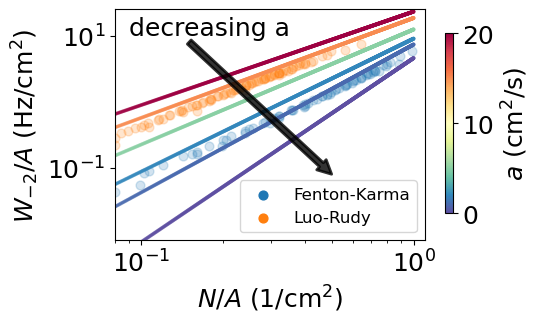

In [138]:
cmap='Spectral'+'_r'
num_points = 25
c_col = 'rmse_full'
fontsize = 18
xytext=(0.09, 10)
x1lim = [8e-2, 1.1]#[1e-1, 1]
x2lim = [8e-3, 25]
# x2lim = [4e-3, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize=(4,3)#(5,4)
fig, ax = plt.subplots(figsize=figsize)

# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))
vmin = 0
vmax = 20#np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    x_values = np.linspace(0, 1, 1000)
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot 
    ax.scatter(x_values,y_values,
               c=c_values,cmap=cmap,alpha=0.6,s=3,vmin=vmin,vmax=vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(ax,
           x1lim=x1lim,
           x2lim=x2lim,
           x1label=r'$N/A$ (1/cm$^{2}$)',#q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
           x2label=r'$W_{-2}/A$ (Hz/cm$^{2}$)',#w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
           title=None,
           fontsize=fontsize,
           use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

#plot the full models
ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

#plot arrow annotation
ax.annotate("decreasing a", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
ax.annotate("", xy=(0.5, 0.08), xytext=(0.15, 8),#,zorder=-1e8,#zorder can send to back
            arrowprops=dict(lw=2,headwidth=10.,headlength=10.,color='k',alpha=0.8))#arrowstyle="->",

leg=ax.legend(loc='lower right',fontsize=fontsize-6)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()
#TODO: lower fontsize in the yticksllabels only

In [139]:
# matplotlib.colors.get_named_colors_mapping()

In [140]:
#DONE(easy): plot the original full model annihilation rate measurements
#DONE: find previous "decreasing a" plot NOT from 'Generating Annihilation Rate Plots from Remote Cache of Particle Model.ipynb'
#TODO: merge ^those
#TODO: perform basic edits to match sketch

# DONE: generate Fig. 2A  individually
- for 2A as the best fits to the particle models (blue) FK and (orange) LR.
    - try showing loglog fit first
- for 2B as the residuals with (dashed) a=0 and (solid) a>0 for both of the full models?

In [181]:
# recall_particle_model_interp?

In [184]:
#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()

# input_fn=f"{nb_dir}/data/osg_output/run_15_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv" #works for many (L=10)
# L=10
input_fn=f"{nb_dir}/data/osg_output/run_25_all_powerlaw_fits.csv" # (L=5)
L=5

input_fn_dict={'vectorsummed':input_fn,'neighboronly':input_fn}
interp=recall_particle_model_interp(input_fn_dict=input_fn_dict,L=L,mode='neighboronly')
# interp=recall_particle_model_interp(input_fn_dict=input_fn_dict)
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

estimated runtime is ~20 seconds for 17988 training samples...
number of training examples is 17640....
training complete!


In [199]:
1

1

In [200]:
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()
# D_hat_FK=0
# D_hat_LR=0

# a_hat_LR=3.535902#-2*0.58 
# a_hat_LR=3.535902#-2*0.58 
# a_hat_LR_long=3.535902#-2*0.58 

# a_hat_FK=1.604153# - 2*0.365
# a_hat_FK_long=1.604153# - 2*0.365

D_hat_FK=0.365
D_hat_LR=0.58

In [201]:
# #FK 200x200, diffCoeff=0.001
# # src: TT
# alinear=1.12
# D=.365
# # src: wjr
# M=5.57# +/- (30)
# nu=1.877# +/- (25)
# L=5

# #didn't work...
# #LR 200x200, diffCoeff=0.0005
# # src: TT
# alinear=2.76 
# D=0.58
# # src: wjr
# M=16.73# +/- (84)
# nu=1.638# +/- (17)
# L=5

#TODO: fix interp_magnitude(x1,x2,x3,x4) to an observed value from the full model

# #FK 200x200, diffCoeff=0.0005, src: WJ
a=1.553
D=0.5
# D=0.114
# # M=2.7 # +/- (1.3) #hmean, my measurement
# # nu=0.84 # +/- (17)#hmean, my measurement
# L=5

# M=5.57#5.807  #   #hmean?, wj's measurement
# nu=1.877 #   #hmean?, wj's measurement

#LR 200x200, diffCoeff=0.001, src: WJ
# a=9.969
# D=0.09
# M=12.6 # +/- (3.8)  #hmean, my measurement
# nu=1.20 # +/- (8)   #hmean, my measurement
# L=5
# M=16.73#19.62  #   #hmean?, wj's measurement
# nu=1.638 #   #hmean?, wj's measurement

In [202]:
# #recall results from tables in the main mansucript..
# wjr=recall_powerlaw_fits_to_full_models()
# interp=recall_particle_model_interp()
# a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

In [203]:
#enter experimental attraction coefficients as substitute
# SMS:
# -  FK: ahat=1.65037
# MS:
# - FK: ahat=1.8876
#heretim

In [204]:
# #FK 200x200, diffCoeff=0.0005, src: WJ
a=1.553
#guessed
D=0.5

In [206]:
df.describe().T[['min','max']].T

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,q_min,q_max,r,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt
min,1.373735,0.018717,1.607750,0.091699,0.987514,0.009421,0.088233,0.24,0.7,0.01,...,0.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.00001,0.00001
max,5.470393,0.375955,516.569239,610.191045,0.999933,3.628193,38.908264,0.24,0.7,0.49,...,0.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.00001,0.00001


In [207]:
0.7/4,2/4,

(0.175, 0.5)

In [208]:
# # ahat=1.8876  #rmse=0.04109107558241248 (FK)  # GammaBar with trivial trajectories
# ahat=1.65037#rmse=2.041284178317197e-08 (FK) # GammaBar without trivial trajectories
# a=ahat;
#,wjr=wjr,interp=interp,ax=ax,
# a=a_hat_FK_vlong;D=D_hat_FK#rmse=0.006797222653889483 (FK)
# a_hat_FK
# a=a_hat_FK;D=D_hat_FK #rmse=2.041284178317197e-08 (FK) #with ahat=1.65037

a=a_hat_FK;
D=D_hat_FK

In [209]:
# wjr['lr_pbc']
# a,D


In [210]:
model_name='fk_pbc'#;c='C0'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
args=a,D,q_values,w_values,interp

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu

q_values_fk=q_values.copy()
what_values_fk=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (FK) ")
dict_fk=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=1.65037, D=0.365, r=0.1, kappa=500.0, rmse=nan (FK) 


In [211]:
#enter experimental attraction coefficients as substitute

# TODO: test powerlaw fits of linear particle model for
# SMS:
# -  LR: ahat=9.60637,7.28148
# -  FK: ahat=1.65037
# MS:
# - LR: ahat=7.13454,4.99485
# - FK: ahat=1.8876
#heretim
# L

In [218]:
#200x200, diffCO0ff=0.0005, (FK) (src: WJ)
a=1.553  
D=.114

# #200x200, diffCO0ff=0.001, (FK) (src: TT)
# a=1.12  *4
# D=.365   *4

model_name='fk_pbc'#;c='C0'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']



q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
args=a,D,q_values,w_values,interp

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=M_full
# nu=nu_full
what_values=M*q_values**nu

q_values_fk=q_values.copy()
what_values_fk=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (FK) fit to {M=}, {nu=}")
dict_fk=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=1.553, D=0.114, r=0.017781397592813993, kappa=579.99890233808, rmse=0.17419668083508041 (FK) fit to M=5.829048139230627, nu=2.209161916893618


In [219]:
# #victor for LR: SMS with GammaBar computed from the average of all spiral tip observations
# # SMS:a=9.60637, D=0.586055, r=0.11865725394705823, kappa=453.30813258922205, rmse=0.031175747845115034 (LR)
# ahat=9.60637#rmse=0.031175747845115034 (LR)
# # ahat=7.28148 #rmse=0.16022186827576143 (LR)
# # MS:
# # ahat=4.99485 # rmse=0.4555348657752726 (LR)
# # ahat=7.13454# rmse=0.17979087126721505 (LR)
# a=ahat;
# a=a_hat_LR
# D=D_hat_LR     #^those

# LR 200x200, diffCoeff=0.001 (src: WJ)
a=9.969
D=0.09     
# a=9.969    *4
# D=0.09     *4

# # #LR 200x200, diffCoeff=0.0005 (src: WJ)
# a=2.767   
# D=0.58    

# a=a_hat_LR;D=D_hat_LR #rmse=0.028075538795257697 (LR)
model_name='lr_pbc'#;c='C1'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=M_full
# nu=nu_full

what_values=M*q_values**nu

q_values_lr=q_values.copy()
what_values_lr=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (LR) fit to {M=}, {nu=}")
dict_lr=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=9.969, D=0.09, r=0.10167659656211231, kappa=331.6765983125879, rmse=0.26662884058494135 (LR) fit to M=17.11419949285171, nu=1.777195613756067


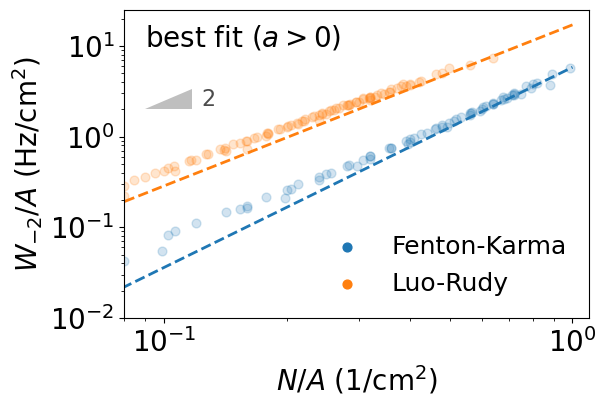

(9.969, 17.11419949285171, 1.777195613756067)

In [217]:
#plot the best fits when a>0
fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
xytext=(0.09, 10)
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

#plot the full models
ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

#plot the result over the original annihilation rates
plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)

#format
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$N/A$ (1/cm$^{2}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
ax.annotate(r"best fit ($a>0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# #mark the slope of ^that line with ~2
# x1 = 0.2
# y1 = 2
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,invert=True,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)    
#mark the slope of ^that line with ~2
x1 = 0.09
y1 = 2
annotation.slope_marker(origin=(x1, y1),
                        slope=2,
                        text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                        poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
                        ax=ax)
# #mark the slope of ^that line with ~3
# x1 = 0.6
# y1 = 0.3
# annotation.slope_marker(origin=(x1, y1),
#                         slope=3,#(3, 1),
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

plt.show()
# print(dict_fk)
# print(dict_lr)
a,M,nu

- a=1.604153, D=0.365, r=0.06044253208765449, kappa=495.47000078959877, rmse=0.006804554125240232 (FK)
- a=3.535902, D=0.58, r=0.135119007149973, kappa=599.9999001383585, rmse=0.77344154837527         (LR)

- a=1.65037, D=0.365, r=0.05782595089352863, kappa=514.0315155197962,  rmse=2.4886791584465667e-08 (FK)
- a=2.375902, D=0.58, r=0.1628483139602805,  kappa=462.41046982400314, rmse=1.0819217469564617     (LR)

In [96]:
1.604153 - 2*0.365 #FK

0.874153

In [51]:
3.535902-2*0.58 #LR

2.375902

# DONE: generate powerlaw fits directly from observed mean collision time 

In [23]:
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_20_all/job.out.21377943.2385"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all/job.out.19842066.24"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_18_all/job.out.16106771.17"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all/job.out.15270959.1"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/black_star_run_1_all/out.0"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_16_all/job.out.14688026.14"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/job.out.13954413.14"
printing=True
npartitions=os.cpu_count()
# kwargs={}
kwargs=dict(npartitions=npartitions)
save_dir=gener_df_powerlaw_fits_and_to_csv(input_fn,**kwargs)

testing input_fn
{'m': 2.348691687055711, 'Delta_m': 0.01579402321139273, 'M': 8.45369889951118, 'Delta_M': 0.285922297679015, 'Rsq': 0.99897695178761, 'rmse': 0.15705548701034783, 'rmse_full': 0.43658535881740856, 'model_name_full': 'fk_ncbc', 'q_min': 0.1, 'q_max': 1.0, 'r': 0.07, 'kappa': 1500, 'D': 6.6, 'varkappa': 0, 'x0': 0, 'L': 10, 'force_code': 2, 'neighbor': 1, 'reflect': 0, 'set_second': 0, 'no_repulsion': 0, 'no_attraction': 0, 'dt': 1e-05, 'Dt': 1e-05}
parsing absolute directory of input_fn=/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_20_all/job.out.21377943.2385...
We're about to use 12 cores to obliterate 4018 csv files from /home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_20_all
run time for computing powerlaw fits was 20.78 seconds.
computed powerlaw fits for  4017 trials successfully.
parsing absolute directory of input_fn=/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_20_all/job.out.21377943.2385...
power

# DONE: generate Fig. 2B individually
- for 2B as the best fits to the particle models (blue) FK and (orange) LR when a=0
- for 2B as the residuals with (dashed) a=0 and (solid) a>0 for both of the full models?

In [24]:
#is a=2D in the annihilation rate fits? no.

In [25]:
for run_num in range(21):
    input_fn= f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all_powerlaw_fits.csv"
    try:
        df=pd.read_csv(input_fn)
        print(f"run #{run_num}: {df[df['varkappa']==0].shape}")
    except Exception as e:
        pass

run #5: (3242, 22)
run #6: (181944, 24)
run #15: (382, 22)
run #16: (0, 22)
run #17: (0, 22)
run #18: (0, 22)
run #19: (0, 22)
run #20: (4017, 24)


In [26]:
#DONE: see here if any df from pd.read_csv(input_fn) has powerlaws for the a=0 case
#DONE: try a bunch of run_num
# run_num=5 # uses the 'beta' column to show funny reaction rates/ranges didn't work
run_num=6
# run_num=15 #worked (N=186)
# run_num=20 #worked? (N=?) Enot really working#4017
# run_num=15#382
input_fn= f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all_powerlaw_fits.csv"
input_fn_dict={'vectorsummed':input_fn,'neighboronly':input_fn}

#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

df=pd.read_csv(input_fn)
print(f"varkappa values: {np.unique(df['varkappa'].values)}")
df.shape

varkappa values: [0]


(181944, 24)

In [27]:
#DONE: root cause analysis on why broken: recall_particle_model_interp_unattractive. answer mode='neighboronly' for run 20...
interp_unattractive=recall_particle_model_interp_unattractive(input_fn_dict=input_fn_dict,#mode='neighboronly',
                                                              printing=True,testing=True)#,L=None)

estimated runtime is ~140 seconds for 17988 training samples...
number of training examples is 1687....
training complete!
shape of X (1687, 3) --> shape of y=yhat (1687, 2)
Example Usage:
yhat=interp(X)
the rmse of simple interpolation is 0.0000


In [28]:
# #recall fits from lib
# # a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
# # print(f"a={a},    D={D}, r={r}, kappa={kappa},  rmse={rmse}")
# a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
# # print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

# D=D_hat_FK
# kappa=500
# r=0.3#needed because the smaller r values havent' finished yet...
# a=0

In [29]:
#TODO: try dev function from ['r','kappa','D'] to mse, as before
#TODO: modify old routine for multidimensional optimization to here
#TODO: generate fig. 2B
#TODO: update drive
#TODO: see if a particle fit works when a=2D
# np.min(X[:,0]),np.max(X[:,0])

In [30]:
model_name='fk_pbc'
D=D_hat_FK
kappa=500
r=0.3#needed because the smaller r values havent' finished yet...
a=0

#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
args=q_values,w_values,interp_unattractive

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
bnds = ((0.01, 0.5), (250, 1500),(0.1,8.))
# bnds = ((0.3, 0.5), (250, 1500),(0.1,8.))
# x0 = (r,kappa,D)
x0 = (0.3,kappa,D)

res = minimize(comp_mse_via_interp_unattractive, x0, args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp_unattractive(res.x, *args)
rmse=np.sqrt(mse)

#compute the resulting annihilation rates
a=0
r=res.x[0]
kappa=res.x[1]
D=res.x[2]
X=np.array([r,kappa,D])
yhat = interp_unattractive(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu

q_values_fk=q_values.copy()
what_values_fk=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (FK)")
dict_fk_unattractive=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=0, D=4.998975853600221, r=0.12254632061727341, kappa=250.0, rmse=0.14588114790017753 (FK)


In [31]:
# X=np.array([r,kappa,D])
# yhat = interp_unattractive(X)

In [32]:
model_name='lr_pbc'
# D=D_hat_LR
D=5
kappa=500
r=0.15#needed because the smaller r values havent' finished yet...
a=0

#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
args=q_values,w_values,interp_unattractive

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
bnds = ((0.01, 0.5), (250, 1500),(0.1,8.))
# bnds = ((0.3, 0.5), (250, 1500),(0.1,8.))
# x0 = (r,kappa,D)
x0 = (0.3,kappa,D)

res = minimize(comp_mse_via_interp_unattractive, x0, args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp_unattractive(res.x, *args)
rmse=np.sqrt(mse)

# #compute the resulting annihilation rates
# a=0
# r=res.x[0]
# kappa=res.x[1]
# X=np.array([[r,kappa,D]])
# yhat = interp(X)
# nu=yhat[0,0]
# M=yhat[0,1]
# what_values=M*q_values**nu

# q_values_fk=q_values.copy()
# what_values_fk=what_values.copy()
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (FK)")
# dict_fk_unattractive=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)


#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]#*1.7
D=res.x[2]
X=np.array([r,kappa,D])
yhat = interp_unattractive(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu

q_values_lr=q_values.copy()
what_values_lr=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (LR)")
dict_lr_unattractive=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=0, D=5.0, r=0.3, kappa=500.0, rmse=20.731065688766602 (LR)


In [33]:
#DONE: simplify ^that
#DONE: repeat ^that for LR
#TODO: generate plot
#TODO: update!

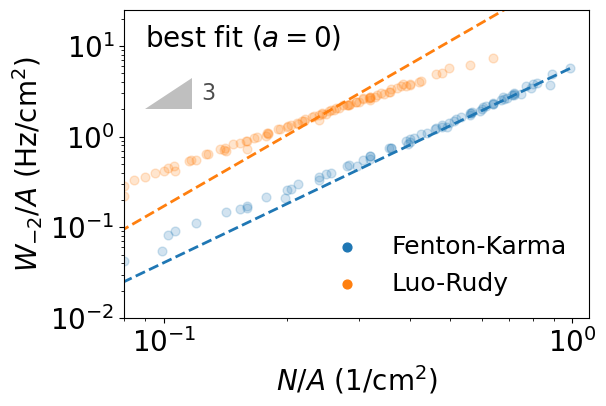

In [34]:
#plot the best fits when a>0
fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

#plot the full models
ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

#plot the result over the original annihilation rates
plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)

#format
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$N/A$ (1/cm$^{2}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
ax.annotate(r"best fit ($a=0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
# #mark the slope of ^that line with ~2
x1 = 0.09
y1 = 2
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
#mark the slope of ^that line with ~3
# x1 = 0.6
# y1 = 0.3
annotation.slope_marker(origin=(x1, y1),
                        slope=3,#(3, 1),
                        text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                        poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
                        ax=ax)

plt.show()

# DONE: Plot MSD for the full models

In [234]:
#options for FK
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/bootstrapped_msd_time_bins_auto.csv"
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/bootstrapped_msd_particle_bins_auto.csv"
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/bootstrapped_msd_particle_bins_30.csv"
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/bootstrapped_msd_particle_bins_auto.csv"
df=pd.read_csv(input_fn)
x_col='lagt_sec'
y_col='msd_cm2'#,ax=ax,c='C0',lw=2,label='Fenton-Karma')
yerr_col='Delta_msd_cm2'
yhat_col='hat_msd_cm2'
x_values_FK=df[x_col].values
y_values_FK=df[y_col].values
yerr_values_FK=df[yerr_col].values
yhat_values_FK=df[yhat_col].values

In [235]:
#options for LR
#options for LR
folder_lr="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5"
# folder_lr="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001"
os.chdir(folder_lr)
# bootstrapped_msd_particle_bins_30.csv
# bootstrapped_msd_particle_bins_auto.csv
# bootstrapped_msd_time_bins_30.csv
# input_fn="bootstrapped_msd_time_bins_30.csv"
# input_fn="bootstrapped_msd_particle_bins_auto.csv"
input_fn="bootstrapped_msd_particle_bins_30.csv"
df=pd.read_csv(input_fn)
x_col='lagt_sec'
y_col='msd_cm2'#,ax=ax,c='C0',lw=2,label='Fenton-Karma')
yerr_col='Delta_msd_cm2'
yhat_col='hat_msd_cm2'
x_values_LR=df[x_col].values
y_values_LR=df[y_col].values
yerr_values_LR=df[yerr_col].values
yhat_values_LR=df[yhat_col].values

In [236]:
#fit to FK
tmin=.5#s
tmax=2#s
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=(x_values>=tmin)&(x_values<tmax) #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/2
Delta_a_SR=dict_a_SR['Delta_m']/2
print(f"D_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmin={tmin}, tmax={tmax} (FK)")
a_hat_FK=a_SR
dict_fit_FK=dict_a_SR

#fit to LR
# tmin=.15#s
# tmax=.4#s
tmin=.1#s
tmax=.4#s
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=(x_values>=tmin)&(x_values<tmax) #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/2
Delta_a_SR=dict_a_SR['Delta_m']/2
print(f"D_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmin={tmin}, tmax={tmax} (LR)")
a_hat_LR=a_SR
dict_fit_LR=dict_a_SR

D_hat_FK = 0.784341+/-0.008310 cm^2/s, tmin=0.5, tmax=2 (FK)
D_hat_LR = 0.768186+/-0.322757 cm^2/s, tmin=0.1, tmax=0.4 (LR)


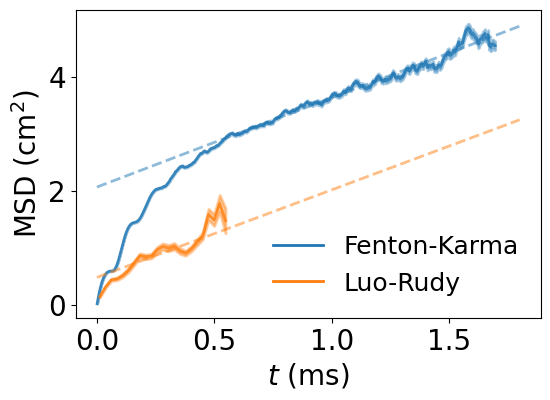

In [237]:
#plot the best fits when a>0
fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig,ax=plt.subplots(figsize=figsize)
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0',label='Fenton-Karma')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
#plot fits

yhat_values_FK
xv=np.linspace(0,1.8,100)
yhat_values_FK=dict_fit_FK['m']*xv+dict_fit_FK['b']
yhat_values_LR=dict_fit_LR['m']*xv+dict_fit_LR['b']
plt.plot(xv,yhat_values_FK,'--',lw=2,alpha=0.5,c='C0')#,label='Fenton-Karma')
plt.plot(xv,yhat_values_LR,'--',lw=2,alpha=0.5,c='C1')#,label='Fenton-Karma')


#format plot
format_plot(ax=plt.gca(),xlabel=r'$t$ (ms)',ylabel=r'MSD (cm$^2$)',fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
# plt.ylim([0,3.1])
plt.show()

In [ ]:
#other files to try to represent LR model
# bootstrapped_msd_particle_bins_30.csv
# bootstrapped_msd_particle_bins_auto.csv
# bootstrapped_msd_time_bins_30.csv
# creations
# creations_minr_1.0_mindur_20.0.csv
# ensemble_msd_particle_bins_30_minlifetime_300.0_cropstartby_0_cropendby_150.csv
# ensemble_msd_particle_bins_auto_minlifetime_150.0_cropstartby_0_cropendby_150.csv
# ensemble_msd_particle_bins_auto_minlifetime_300.0_cropstartby_0_cropendby_150.csv
# ensemble_msd_time_bins_30_minlifetime_300.0_cropstartby_0_cropendby_150.csv
# fig
# Log
# msd
# msd_particle_minlifetime_150.0_cropstartby_0_cropendby_150.csv
# msd_particle_minlifetime_300.0_cropstartby_0_cropendby_150.csv
# msd_time_minlifetime_300.0_cropstartby_0_cropendby_150.csv


# scratchwerk

In [ ]:
#Option 1: find the exact MSD plots I made before
#Option 2: compute MSD from the following:

In [138]:
# # file=search_for_file()
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/all_traj_longer_than_1000.csv'

T_min=1000#ms
omit_time=150#ms
DS=0.025#cm/pixel
figsize=(17,4);fontsize=16
saving=False

# df=pd.read_csv(file)
# DT=compute_time_between_frames(df);print(f"DT={DT}")

# df=return_unwrapped_trajectory(df, width, height, sr, mem, dsdpixel, **kwargs)
# df=get_all_longer_than(df,DT,T_min=T_min)

# #count remaining individuals
# num_individuals=len(list(set(df.particle.values)));print(f"num_individuals={num_individuals}")
# emsd=compute_emsd(traj=df.copy(), DT=DT, omit_time=omit_time, printing=False,DS=DS)


# #save emsd
# savefn=f"emsd_longer_than_{T_min}.csv"
# os.chdir(savefig_folder)
# emsd.to_csv(savefn)#,index=False)
# os.path.abspath(savefn)
# # emsd

file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/archived_msd/emsd_longer_than_1000.csv'
DT=0.4
num_individuals=4064
emsd=pd.read_csv(file,index_col='lagt')
# lag_values,slope_values=compute_slope_vs_lag(emsd,T_min,omit_time,window_width=50,stepsize=10)

savefig_folder=os.path.dirname(file)#os.path.join(nb_dir,'Figures/msd_loglog')
savefig_fn=os.path.basename(file).replace('.csv','.png')#f'logMSD_vs_loglag_Tmin_{T_min/10**3:.1f}_N_{trials_considered}_mni_{min_num_individuals}.png'


fig,axs=plt.subplots(ncols=3,figsize=figsize)
plot_emsd(axs[0],emsd,label='_Hidden', color='black',alpha=1.)
format_plot_emsd(axs[0],use_loglog=False,fontsize=fontsize)

plot_emsd(axs[1],emsd,label='_Hidden', color='black',alpha=1.)
format_plot_emsd(axs[1],use_loglog=True,fontsize=fontsize)

lag_values,slope_values=compute_slope_vs_lag(emsd,T_min,omit_time,window_width=500,stepsize=10)
plot_slope_of_emsd(axs[2],lag_values,slope_values,label='_Hidden', color='black', alpha=1.,plot_reference_lines=True)

format_slope_of_emsd(axs[2],fontsize=fontsize,use_loglog=False)

if not saving:
    plt.tight_layout()
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

#compute and print v_rms and D
# compute diffusion coefficient and rms velocity of spiral tips
v_rms,Delta_v_rms,_,_,Rsquared_v,_=compute_v_rms(emsd,num_points=8)
Dhat,Delta_Dhat,tau_min,tau_max,Rsquared_D,delta_tau=compute_Dhat(emsd,tau_min=300,window_width=500)

# Dhat,Delta_Dhat,tau_min,tau_max,Rsquared_D,delta_tau=compute_Dhat(emsd,tau_min=200,MSD_thresh=.2,max_lagtime=50)
print(f"make sure the right DT scale was used!")
print(f"make sure to record in spreadsheet!")
print(f"time window for D was from {tau_min:.0f} to {tau_max:.0f} ms.")
print(f"D = {Dhat} +- {Delta_Dhat} cm^2/s... Rsq={Rsquared_D}")
print(f"v_rms = {v_rms} +- {Delta_v_rms} cm/s... Rsq={Rsquared_v}")


#make pd.DataFrame that can be copy/pasted to a spreadsheet
df_output=pd.DataFrame({
    'exponent_final':slope_values[-1],
    'exponent_500':slope_values[lag_values==.5][0],
    "Dhat":[Dhat],
    "Delta_Dhat":[Delta_Dhat],
    "Rsquared_D":[Rsquared_D],
    "v_rms":v_rms,
    "Delta_v_rms":Delta_v_rms,
    "Rsquared_v":Rsquared_v,
    "num_individuals":num_individuals,
    "diffCoef":0.0005,
    'area':25,
    'model':'param_set_8'
})
print(num_individuals)
df_output

NameError: name 'plot_emsd' is not defined

## scratchwerk

In [136]:
compute_each_mean_squared_displacement_particle

NameError: name 'compute_each_mean_squared_displacement_particle' is not defined

In [134]:
# LR results for DT = 0.5 ms
modelname='luo-rudy'
# annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"
# # # #creations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/creations_minr_1.0_mindur_20.0.csv"
df_lr=pd.read_csv(input_fn)

# #LR results for DT = 0.025 ms
# #annihilations aggregated
# # input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
# # # #creations aggregated
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/creations_minr_1.0_mindur_20.0.csv'

# df_lr=pd.read_csv(input_fn)
# #FK results for DT = 0.4 ms
# #annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilations_minr_1.0_mindur_20.0.csv"
# #creations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/creations_minr_1.0_mindur_20.0.csv"
df_fk=pd.read_csv(input_fn)

df_fk.sort_values('tbirth',ascending=True,inplace=True)
df_lr.sort_values('tbirth',ascending=True,inplace=True)

# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")

#compute xy values
x_label='time (ms)'#'t'
# x_label='time after annihilation (ms)'#'t'
y_label='inward/outward\nangle (radians)'#'$\vartheta$'
# 'r (cm)'
# 'dr/dt (cm/ms)'

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
x_values_lr=dfm.index.values
y_values_lr=dfm.theta.values
yerr_values_lr=dfs.theta.values

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
x_values_fk=dfm.index.values
y_values_fk=dfm.theta.values
yerr_values_fk=dfs.theta.values

In [135]:
dfm.head()

,pid,pid_birthmate,r,theta
tbirth,,,,
0.4,196.076023,195.935545,0.249673,3.017857
0.8,196.076023,195.935545,0.301823,2.987414
1.2,196.076023,195.935545,0.343790,2.964233
1.6,196.076023,195.935545,0.380089,2.944923
2.0,196.076023,195.935545,0.412202,2.927226


In [ ]:
# def compute_each_mean_squared_displacement_particle(input_fn,
#                                                     DT,
#                                                     ds,
#                                                     width,
#                                                     minimum_lifetime,
#                                                     crop_start_by,
#                                                     crop_end_by,
#                                                     pid_col,
#                                                     t_col,
#                                                     max_lagtime=None,
#                                                     use_unwrap=False,
#                                                     **kwargs):

#     DS = ds / width
#     df = pd.read_csv(input_fn)
#     DT = get_DT(df, t_col=t_col, pid_col=pid_col)
#     if use_unwrap is True:
#         #unwrap trajectories
#         pid_lst = sorted(set(df[pid_col].values))
#         #(duplicates filtered earlier in full model pipeline.  Unnecessary in particle model with explicit tracking_ _  _ _ ) filter_duplicate_trajectory_indices is slow (and can probs be accelerated with a sexy pandas one liner)
#         # pid_lst_filtered = filter_duplicate_trajectory_indices(pid_lst,df)
#         df = pd.concat([
#             unwrap_traj_and_center(df[df[pid_col] == pid],
#                                    width=width,
#                                    height=height,
#                                    **kwargs) for pid in pid_lst
#         ])

#     #compute t0 and tf for each particle
#     dft = df.groupby(pid_col)[t_col].describe()
#     dft0 = dft['min']
#     dftf = dft['max']

#     #compute t1 and t2 for each particle
#     dft1 = dft0 + crop_start_by
#     dft2 = dftf - crop_end_by

#     #get the list of particles dft2-dft1 \ge minimum_lifetime
#     dflifetime_considered = dft2 - dft1
#     pid_values_to_consider = dflifetime_considered[
#         dflifetime_considered >= minimum_lifetime].index.values

#     #compute number of num_individuals
#     # pid_lst=sorted(set(df[pid_col].values))
#     num_individuals = len(list(pid_values_to_consider))
#     # print(f'Computing msd values for {num_individuals} particles...')

#     #for each particle, set lagt equal to the zero'd time
#     event_id_lst = sorted(set(df[id_col].values))
#     for pid in pid_values_to_consider:
#         boo = df[pid_col] == pid
#         tbirth = df.loc[boo, 't'].min()
#         df.loc[boo, 'lagt'] = df.loc[boo, 't'] - tbirth

#     df['msd'] = (df['x']**2 + df['y']**2) * DS**2
#     df['pid'] = df[pid_col]
#     df_msd = df[['pid', 'lagt', 'msd']]
#     return df_msd

In [ ]:
ds = 10
width = 10
height = 10
use_unwrap = True
pid_col = 'pid_explicit'
t_col = 't'
kwargs = {}
id_col = 'pid_explicit'
# id_col='event_id'
use_unwrap = True
max_lagtime=None
minimum_lifetime=100. #ms
crop_start_by=40
crop_end_by=40

df_msd = compute_each_mean_squared_displacement_particle(input_fn,
                                                    DT,
                                                    ds,
                                                    width,
                                                    minimum_lifetime,
                                                    crop_start_by,
                                                    crop_end_by,
                                                    pid_col,
                                                    t_col,
                                                    max_lagtime=max_lagtime,
                                                    use_unwrap=use_unwrap)

In [ ]:
#plot the best fits when a>0
fontsize = 20
figsize = (6, 4)  #(5,4)
alpha=0.5
fig, ax = plt.subplots(figsize=figsize)

# #plot the full models
# ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
# ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

# #plot the result over the original annihilation rates
# plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
# plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)

ax.scatter(1/x_values_fk,-y_values_fk*100,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# ax.scatter(1/x_values_lr,-y_values_lr*100,c='C1',s=40,alpha=alpha,label='Luo-Rudy',zorder=0)

#plot fits
y_hat_values=dict_force_fit_fk['b']*100+dict_force_fit_fk['m']*100/x_values_fk
ax.plot(1/x_values_fk,-y_hat_values,'--',c='C0',lw=2,alpha=0.7)
# ax.plot(1/x_values_fk,-y_hat_values_fk*100,'--',c='C0',lw=2,alpha=1)
# ax.plot(1/x_values_lr,-y_hat_values_lr*100,'--',c='C1',lw=2,alpha=1)
ax.plot(1/x_values_fk,0.*y_hat_values,'k--',lw=2,alpha=0.4)



#format
x1lim=[.7,5]
x2lim=[-0.2e2,.1e2]
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$1/R$ (cm$^{-1}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$dR/dt$ (cm/s)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=False)
ax.annotate(r"best fit ($a>0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
# leg=ax.legend(loc='upper right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# #mark the slope of ^that line with ~2
# x1 = 1
# y1 = 0.1
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

# DONE: generate dRdt vs. 1/R plot for the full models

In [459]:
msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083
msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

tmax=300#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


In [499]:
#compute dRdt versus R for FK model
# navg=51
# navg=5
navg=151

t_values=df_msd_fk['tdeath_avg'].values
R_values=np.sqrt(df_msd_fk['MSR'].values)
Delta_R_values=df_msd_fk['Delta_MSR'].values/(2*R_values)
# Delta_R_values=np.sqrt(df_msd_fk['Delta_MSR'].values)

R_values_ = savgol_filter(x=R_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')

dR_values_ = savgol_filter(x=R_values,
    window_length=navg,
    polyorder=3,deriv=1,delta=1.0,axis=-1,mode='interp')

t_values_ = savgol_filter(x=t_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
dt_values_ = savgol_filter(x=t_values,
    window_length=navg,
    polyorder=3,deriv=1,delta=1.0,axis=-1,mode='interp')

dRdt_values=dR_values_/dt_values_
R_values_FK=R_values.copy()
dRdt_values_FK=dRdt_values.copy()
# print(f"the smoothing window was {np.mean(navg*dt_values_):.4f} +/- {np.std(navg*dt_values_):.4f} (LR)")
print(f"the smoothing window was {np.mean(navg*dt_values_):.4f} +/- {np.std(navg*dt_values_):.4f} (FK)")
Delta_R_values_= savgol_filter(x=Delta_R_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')

Delta_dRdt_values_FK=2*Delta_R_values_/dt_values_
x_values_FK=R_values_FK
y_values_FK=-dRdt_values_FK*1e3
yerr_values_FK=Delta_dRdt_values_FK*1e3

the smoothing window was 298.8927 +/- 0.0560 (FK)


In [502]:
#compute dRdt versus R for LR model
navg=115
# navg=11

t_values=df_msd_lr['tdeath_avg'].values
R_values=np.sqrt(df_msd_lr['MSR'].values)
Delta_R_values=df_msd_lr['Delta_MSR'].values/(2*R_values)
# Delta_R_values=np.sqrt(df_msd_lr['Delta_MSR'].values)

R_values_ = savgol_filter(x=R_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
dR_values_ = savgol_filter(x=R_values,
    window_length=navg,
    polyorder=3,deriv=1,delta=1.0,axis=-1,mode='interp')

t_values_ = savgol_filter(x=t_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
dt_values_ = savgol_filter(x=t_values,
    window_length=navg,
    polyorder=3,deriv=1,delta=1.0,axis=-1,mode='interp')

dRdt_values=dR_values_/dt_values_
R_values_LR=R_values.copy()
dRdt_values_LR=dRdt_values.copy()
print(f"the smoothing window was {np.mean(navg*dt_values_):.4f} +/- {np.std(navg*dt_values_):.4f} (LR)")
# print(f"the smoothing window was {np.mean(navg*dt_values_):.4f} +/- {np.std(navg*dt_values_):.4f} (FK)")
Delta_R_values_= savgol_filter(x=Delta_R_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
Delta_dRdt_values_LR=2*Delta_R_values_/dt_values_
x_values_LR=R_values_LR
y_values_LR=-dRdt_values_LR*1e3
yerr_values_LR=Delta_dRdt_values_LR*1e3


the smoothing window was 116.9561 +/- 0.0769 (LR)


In [503]:
#compute simple moving averages
navg_ma=15
navg_ma=10

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
x_values_LR=moving_average(x_values_LR,navg_ma)
y_values_LR=moving_average(y_values_LR,navg_ma)
yerr_values_LR=moving_average(yerr_values_LR,navg_ma)
x_values_FK=moving_average(x_values_FK,navg_ma)
y_values_FK=moving_average(y_values_FK,navg_ma)
yerr_values_FK=moving_average(yerr_values_FK,navg_ma)

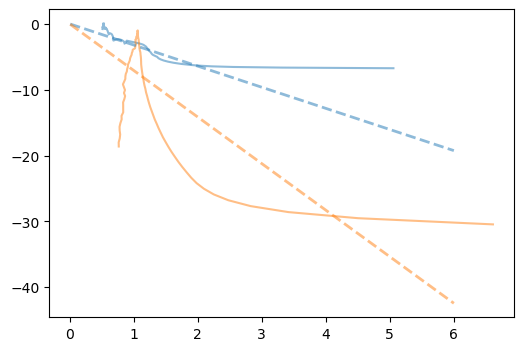

In [504]:
# #DONE: compute dRdt vs. 1/R for R as RMSRdf_msd_lr=pd.read_csv(msr_dir_lr)
# t_values=df_msd_lr['tdeath_avg'].values
# R_values=np.sqrt(df_msd_lr['MSR'].values)
# Delta_R_values=df_msd_lr['Delta_MSR'].values/(2*R_values)
fontsize=15
fig,ax=plt.subplots(figsize=(6,4))
### plot expected
fontsize=20

# #DONE: recall savgol filter to compute dRdt_values

# plt.plot(t_values,R_values)
# # plt.plot(t_values_,R_values_)
# navg_ma=10
# plt.plot(moving_average(1/R_values_FK,navg_ma),-moving_average(dRdt_values_FK,navg_ma)*1e3)
# plt.plot(moving_average(1/R_values_LR,navg_ma),-moving_average(dRdt_values_LR,navg_ma)*1e3)
ax.plot(1/R_values_FK,-dRdt_values_FK*1e3,c='C0',alpha=alpha,label='Fenton-Karma')
ax.plot(1/R_values_LR,-dRdt_values_LR*1e3,c='C1',alpha=alpha,label='Luo-Rudy')
# ax.plot(1/R_values_FK,-dRdt_values_FK*5e2)
# ax.plot(1/R_values_LR,-dRdt_values_LR*5e2)

#plot the expected values
xv=np.linspace(1e-2,6,100)
# plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# ax.plot(xv,-1.8876*2*xv,'C0--',lw=2,alpha=0.5)
plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# plt.plot(xv,-8.595018*2*xv,'C1--',lw=2,alpha=0.5)
# ax.plot(xv,-9.60637*2*xv,'C1--',lw=2,alpha=0.5)
ax.plot(xv,-3.535902*2*xv,'C1--',lw=2,alpha=0.5)


plt.show()

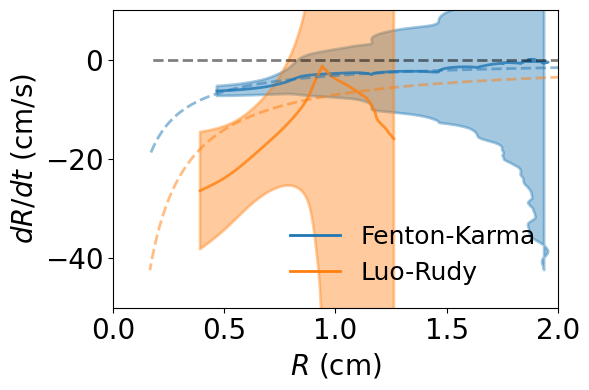

In [505]:
# #DONE: compute dRdt vs. 1/R for R as RMSRdf_msd_lr=pd.read_csv(msr_dir_lr)
# t_values=df_msd_lr['tdeath_avg'].values
# R_values=np.sqrt(df_msd_lr['MSR'].values)
# Delta_R_values=df_msd_lr['Delta_MSR'].values/(2*R_values)
fontsize=15
fig,ax=plt.subplots(figsize=(6,4))
### plot expected
fontsize=20
# ax.scatter(1/R_values_FK,-dRdt_values_FK*1e3,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# # ax.scatter(1/R_values_LR,-dRdt_values_LR*1e3,c='C1',s=40,alpha=alpha,label='Luo-Rudy')
# ax.scatter(R_values_FK,-dRdt_values_FK*1e3,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# ax.scatter(R_values_LR,-dRdt_values_LR*1e3,c='C1',s=40,alpha=alpha,label='Luo-Rudy')

#plot data
ax.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0',label='Fenton-Karma')
ax.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
ax.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
#plot fits


#plot the expected values
xv=np.linspace(1e-2,6,100)
# plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# ax.plot(xv,-1.8876*2*xv,'C0--',lw=2,alpha=0.5)
plt.plot(1/xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# plt.plot(xv,-8.595018*2*xv,'C1--',lw=2,alpha=0.5)
# ax.plot(xv,-9.60637*2*xv,'C1--',lw=2,alpha=0.5)
ax.plot(1/xv,-3.535902*2*xv,'C1--',lw=2,alpha=0.5)

ax.plot(1/xv,0*xv,'k--',lw=2,alpha=0.5)



#format
x1lim=[0,2]
x2lim=[-50,10]
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$R$ (cm)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=r'$dR/dt$ (cm/s)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=False)
ax.annotate(r"best fit ($a>0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

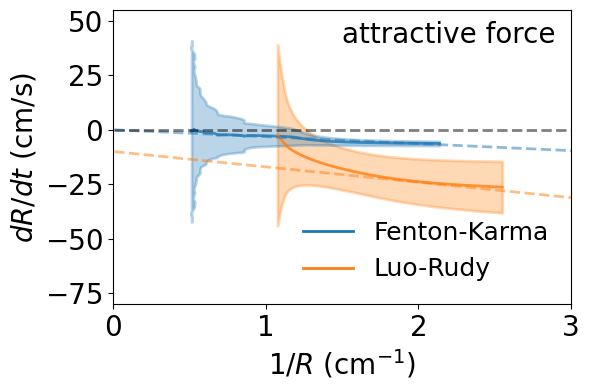

In [556]:
# #DONE: compute dRdt vs. 1/R for R as RMSRdf_msd_lr=pd.read_csv(msr_dir_lr)
# t_values=df_msd_lr['tdeath_avg'].values
# R_values=np.sqrt(df_msd_lr['MSR'].values)
# Delta_R_values=df_msd_lr['Delta_MSR'].values/(2*R_values)
fontsize=15
fig,ax=plt.subplots(figsize=(6,4))
### plot expected
fontsize=20
# ax.scatter(1/R_values_FK,-dRdt_values_FK*1e3,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# # ax.scatter(1/R_values_LR,-dRdt_values_LR*1e3,c='C1',s=40,alpha=alpha,label='Luo-Rudy')
# ax.scatter(R_values_FK,-dRdt_values_FK*1e3,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# ax.scatter(R_values_LR,-dRdt_values_LR*1e3,c='C1',s=40,alpha=alpha,label='Luo-Rudy')

#plot data
ax.plot(1/x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0',label='Fenton-Karma')
ax.fill_between(1/x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.3,color='C0')
# ax.plot(1/x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
# ax.fill_between(1/x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.3,color='C1',zorder=0)
boo=1/x_values_LR>1/0.93
ax.plot(1/x_values_LR[boo],y_values_LR[boo],lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
ax.fill_between(1/x_values_LR[boo],y_values_LR[boo]-yerr_values_LR[boo],y_values_LR[boo]+yerr_values_LR[boo],lw=2,alpha=0.3,color='C1',zorder=0)

#plot the expected values
xv=np.linspace(1e-2,6,100)
# plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# ax.plot(xv,-1.8876*2*xv,'C0--',lw=2,alpha=0.5)
plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# plt.plot(xv,-8.595018*2*xv,'C1--',lw=2,alpha=0.5)
# ax.plot(xv,-9.60637*2*xv,'C1--',lw=2,alpha=0.5)
ax.plot(xv,-3.535902*2*xv-10,'C1--',lw=2,alpha=0.5)

ax.plot(xv,0*xv,'k--',lw=2,alpha=0.5)



#format
x1lim=[0,3]
x2lim=[-80,55]
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$1/R$ (cm$^{-1}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=r'$dR/dt$ (cm/s)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=False)
# xytext=(0.09, 10)
# ax.annotate(r"attractive force", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
xytext=(1.5, 40)
ax.annotate(r"attractive force", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_yticks([-75,-50,-25,0,25,50])
    
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

(0.09, 10)

In [470]:
# fontsize=15
# fig,ax=plt.subplots(figsize=(6,4))
# ### plot expected
# fontsize=20

# xv=np.linspace(0,1e3,200)
# ax.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
# #plot data
# ax.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
# ax.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
# ax.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
# ax.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# # MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# # DONE: plot ^this model for MSR for fitty parameter settings (LR)
# # a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
# a=3.535902;D=a/2;
# phi_f=0.;
# # phi_f=-np.pi/2;
# period=0.12 #s
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# ax.plot(t_values*1e3,MSR_values_oscillatory,c='C2',
#         label='$MSR_{Osc.} (a=a_{LR},\phi_f=0$)')
# #         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

# #what param setting to use for the FK model?
# phi_f=-np.pi/2;
# a=1.604153;
# period=0.11 #s
# D=a/2;
# # constant=0.15
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# ax.plot(t_values*1e3,MSR_values_oscillatory,c='C3',
#                 label=r'$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')
# #         label='$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')
# #         label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

# # #what param setting to use for the FK model?
# # phi_f=0#-np.pi/2;
# # # a=1.604153;
# # # period=0.11 #s
# # # D=a/2;
# # # constant=0.15
# # omega=2*np.pi/period
# # constant=-8*D*np.sin(phi_f)/omega#0.15
# # t_values=np.linspace(0,1,1000)
# # MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# # plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

# #format plot
# format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
# plt.xlim([0,1000])
# plt.ylim([0,5.1])
# plt.legend(loc='lower right',fontsize=fontsize-5,frameon=False)
# plt.show()
# # print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

## (old version) dRdt vs. 1/R for annihilation events

In [40]:
# search_for_file(os.path.dirname(input_fn))

input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_mindur_50_maxdur_150_minrange_0.5_rangethresh_0.1_mean_radial_velocities_bins_30_minRthresh_0.2_maxspeedthresh_0.5.csv'

In [76]:
#LR results for DT = 0.5 ms
# modelname='luo-rudy'
#annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"
# df_lr=pd.read_csv(input_fn)

# #LR results for DT = 0.025 ms
#annihilations aggregated
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"
# # #creations aggregated
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/creations_minr_1.0_mindur_20.0.csv'

df_lr=pd.read_csv(input_fn)
# #FK results for DT = 0.4 ms
# #annihilations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilations_minr_1.0_mindur_20.0.csv"
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv"



# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_mindur_50_maxdur_150_minrange_0.5_rangethresh_0.1_mean_radial_velocities_bins_30_minRthresh_0.2_maxspeedthresh_0.5.csv'
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_mindur_50_maxdur_150_minrange_0.5_rangethresh_0.1_mean_radial_velocities_bins_30.csv'

# #creations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/creations_minr_1.0_mindur_20.0.csv"
df_fk=pd.read_csv(input_fn)

In [77]:
# #LR results for DT = 0.5 ms
# # modelname='luo-rudy'
# #annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"


# # #LR results for DT = 0.025 ms
# #annihilations aggregated
# # input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
# # # #creations aggregated
# # input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/creations_minr_1.0_mindur_20.0.csv'
# df_lr=pd.read_csv(input_fn)

# # #FK results for
# # #annihilations aggregated
# #DT = 0.4 ms
# # input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilations_minr_1.0_mindur_20.0.csv"
# #DT=0.025 ms
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
# df_fk=pd.read_csv(input_fn)

# # input_fn=search_for_file()
# #TODO: make outputs simultaneously visible for LR and FK results (dt=0.5,0.4, respectively)

In [96]:
df_fk['tdeath']
df_fk.head()

,pid,pid_deathmate,tdeath,phi1,phi2,phi_sum,phi_diff,r,theta
2022508,323,319,0.4,0.290670,0.265307,0.025363,0.555978,0.210981,0.309262
506595,65,60,0.4,0.547026,0.484770,0.062256,1.031796,0.181260,0.545626
2016360,234,230,0.4,0.250357,0.230122,0.020235,0.480479,0.164212,0.305135
853772,29,19,0.4,0.468442,0.422671,0.045771,0.891114,0.144394,0.536775
1833408,176,172,0.4,0.173274,0.151883,0.021391,0.325158,0.033116,0.170509


In [79]:
df_fk.sort_values('tdeath',ascending=True,inplace=True)
df_lr.sort_values('tdeath',ascending=True,inplace=True)

In [80]:
# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")

#compute xy values
x_label='time (ms)'#'t'
# x_label='time after annihilation (ms)'#'t'
y_label='inward/outward\nangle (radians)'#'$\vartheta$'
# 'r (cm)'
# 'dr/dt (cm/ms)'

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tdeath.values))
DT=sorted(set(df_phases.tdeath.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
# dfm=df_phases.groupby('tbirth').mean()
# dfs=df_phases.groupby('tbirth').std()
dfm=df_phases.groupby('tdeath').mean()
dfs=df_phases.groupby('tdeath').std()
x_values_lr=dfm.index.values
y_values_lr=dfm.theta.values
yerr_values_lr=dfs.theta.values

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tdeath.values))
DT=sorted(set(df_phases.tdeath.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
# dfm=df_phases.groupby('tbirth').mean()
# dfs=df_phases.groupby('tbirth').std()
dfm=df_phases.groupby('tdeath').mean()
dfs=df_phases.groupby('tdeath').std()
x_values_fk=dfm.index.values
y_values_fk=dfm.theta.values
yerr_values_fk=dfs.theta.values

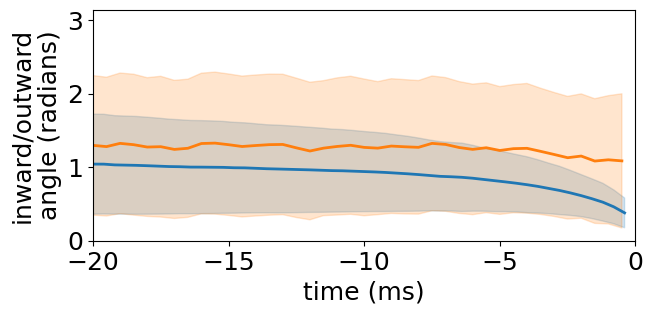

In [81]:
fontsize=18
fig,ax=plt.subplots(ncols=1,figsize=(7,3))#(5,4))
# axes=[1e-1,2,1e-3,0.2]
alpha=0.2
# FK
ax.fill_between(-x_values_fk, y_values_fk-yerr_values_fk, y_values_fk+yerr_values_fk,color='C0',alpha=alpha)
ax.plot(-x_values_fk,y_values_fk,'C0',lw=2)
#LR
ax.fill_between(-x_values_lr, y_values_lr-yerr_values_lr, y_values_lr+yerr_values_lr,color='C1',alpha=alpha)
ax.plot(-x_values_lr,y_values_lr,'C1',lw=2)

#TODO: add cuts for times



ax.set_xlim([-20,0])#-DT])
# ax.set_xlim([-50,-DT])
ax.set_ylim([0,np.pi])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

#wrong bluf because aggregate
# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")
plt.show()

In [117]:
#plot the mean drdt versus r
#compute xy values
x_label='R (cm)'
y_label='dR/dt (cm/ms)'

df_fk.sort_values('tdeath',ascending=True,inplace=True)
df_lr.sort_values('tdeath',ascending=True,inplace=True)

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tdeath.values))
DT=sorted(set(df_phases.tdeath.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
# dfm=df_phases.groupby('tbirth').mean()
# dfs=df_phases.groupby('tbirth').std()
dfm=df_phases.groupby('tdeath').mean()
dfs=df_phases.groupby('tdeath').std()
t_values=dfm.index.values
range_values=dfm.r.values
drdt_values=np.diff(range_values)/DT
r_values=range_values[1:]/2+range_values[:-1]/2
x_values_lr=r_values.copy()
y_values_lr=drdt_values.copy()
# yerr_values_lr=dfs.theta.values

#fit drdt_values to F0+F1/r with OLS fit for LR model where 1/r is greater than some 1/cm
rmax=1.2 #cm
boo=r_values<rmax
x=1/r_values[boo]
y=drdt_values[boo]
dict_force_fit=compute_95CI_ols(x,y)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values

dict_force_fit_lr=dict_force_fit
y_hat_values_lr=y_hat_values.copy()

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tdeath.values))
DT=sorted(set(df_phases.tdeath.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
# dfm=df_phases.groupby('tbirth').mean()
# dfs=df_phases.groupby('tbirth').std()
dfm=df_phases.groupby('tdeath').mean()
dfs=df_phases.groupby('tdeath').std()
t_values=dfm.index.values
range_values=dfm.r.values
drdt_values=np.diff(range_values)/DT
r_values=range_values[1:]/2+range_values[:-1]/2
x_values_fk=r_values.copy()
y_values_fk=drdt_values.copy()
# yerr_values_fk=dfs.theta.values

#fit drdt_values to F0+F1/r with OLS fit for FK model where 1/r is greater than 2 1/cm
rmax=0.5 #cm
boo=r_values<rmax
x=1/r_values[boo]
y=drdt_values[boo]
dict_force_fit=compute_95CI_ols(x,y)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
dict_force_fit_fk=dict_force_fit
y_hat_values_fk=y_hat_values.copy()
DT

0.4

In [118]:
print(f"the best fits are\n {dict_force_fit_lr} (LR) and \n{dict_force_fit_fk} (FK).")

the best fits are
 {'m': -0.04422231513736983, 'Delta_m': 0.05564659598723808, 'b': 0.038442644486729995, 'Delta_b': 0.05347057224331184, 'Rsquared': 0.012351468067116794} (LR) and 
{'m': 0.03728256788539019, 'Delta_m': 0.0006336154335623624, 'b': -0.048669499427550326, 'Delta_b': 0.001794174887640679, 'Rsquared': 0.9990235572199276} (FK).


In [84]:
# def print_dict(input_dict):
#     for key in input_dict.keys():
#         print(f"{key}={input_dict[key]}")
r_values

array([0.21120453, 0.25593874, 0.29152921, ..., 1.83470333, 1.83077765,
       1.82552717])

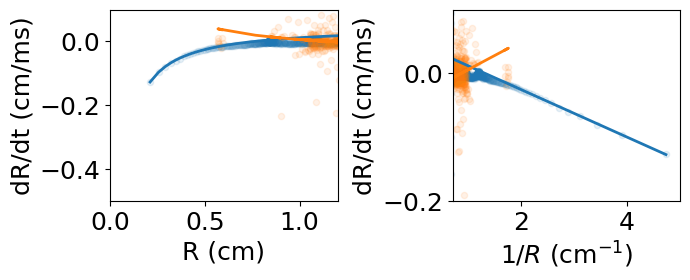

In [86]:
fontsize=18
alpha=0.1

fig,axs=plt.subplots(ncols=2,figsize=(7,3))#(5,4))
ax=axs[0]
ax.scatter(x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
ax.scatter(x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
ax.plot(x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

ax.set_xlim([0,1.2])
ax.set_ylim([-0.5,.1])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

ax=axs[1]
ax.scatter(1/x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
ax.scatter(1/x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(1/x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
ax.plot(1/x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

# y_hat_values_fk
# y_hat_values_fk

ax.set_xlim([.7,5])
ax.set_ylim([-0.2,.1])
ax.set_xlabel(r'$1/R$ (cm$^{-1}$)',fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

$$
F(R)\propto\frac{dR}{dt} = b + \frac{m}{R}
$$

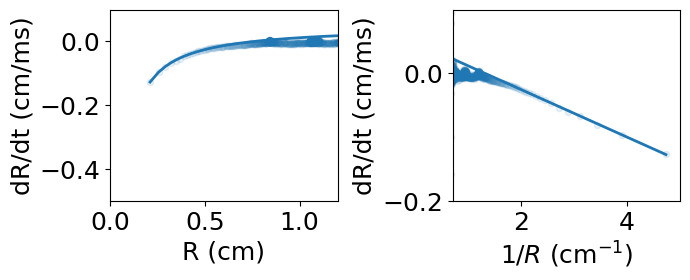

In [97]:
fontsize=18
alpha=0.1

fig,axs=plt.subplots(ncols=2,figsize=(7,3))#(5,4))
ax=axs[0]
ax.scatter(x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
# ax.scatter(x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
# ax.plot(x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

ax.set_xlim([0,1.2])
ax.set_ylim([-0.5,.1])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

ax=axs[1]
ax.scatter(1/x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
# ax.scatter(1/x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(1/x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
# ax.plot(1/x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

# y_hat_values_fk
# y_hat_values_fk

ax.set_xlim([.7,5])
ax.set_ylim([-0.2,.1])
ax.set_xlabel(r'$1/R$ (cm$^{-1}$)',fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

In [124]:
a_fk=dict_force_fit_fk['m']/2*1000
a_fk=dict_force_fit_fk['m']/2*100
Delta_a_fk=dict_force_fit_fk['Delta_m']/2*100
print(f'the apparent attraction coefficient for the fenton-karma model is a={a_fk:.4f} +/- {Delta_a_fk:.4f} cm^2/s.')

the apparent attraction coefficient for the fenton-karma model is a=1.8641 +/- 0.0317 cm^2/s.


In [122]:
nobs=df_fk.groupby('tdeath').r.count().iloc[0]
print(f"nobs={nobs} (FK)")
nobs=df_lr.groupby('tdeath').r.count().iloc[0]
print(f"nobs={nobs} (LR)")

nobs=3010 (FK)
nobs=744 (LR)


In [85]:
#TODO: try any more annihilation plots... 
# HINT: any from the following 3 panel
# HINT: are phi values present/convenient? Yes.
#TODO: condense the figures we like into functions. test on FK model
#TODO: make comparable functions for LR model. 

In [52]:
print(f"the ols fit for FK:")
print_dict(dict_force_fit_fk)
print(f"\nthe ols fit for LR:")
print_dict(dict_force_fit_lr)

the ols fit for FK:
m=0.03728256788539025
Delta_m=0.0006336154335623547
b=-0.04866949942755054
Delta_b=0.0017941748876406575
Rsquared=0.9990235572199276

the ols fit for LR:
m=-0.04422231513736985
Delta_m=0.05564659598723807
b=0.03844264448673002
Delta_b=0.05347057224331182
Rsquared=0.012351468067116686


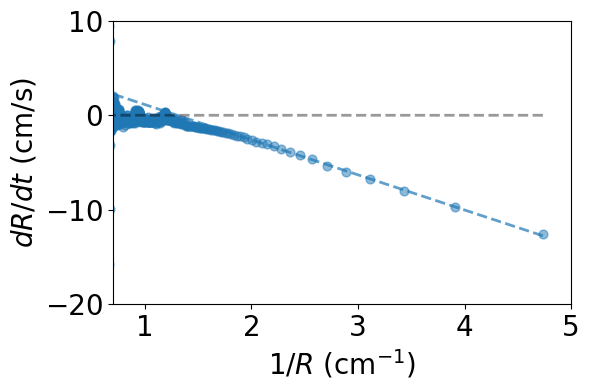

In [132]:
#plot the best fits when a>0
fontsize = 20
figsize = (6, 4)  #(5,4)
alpha=0.5
fig, ax = plt.subplots(figsize=figsize)

# #plot the full models
# ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
# ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

# #plot the result over the original annihilation rates
# plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
# plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)

ax.scatter(1/x_values_fk,-y_values_fk*100,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# ax.scatter(1/x_values_lr,-y_values_lr*100,c='C1',s=40,alpha=alpha,label='Luo-Rudy',zorder=0)

#plot fits
y_hat_values=dict_force_fit_fk['b']*100+dict_force_fit_fk['m']*100/x_values_fk
ax.plot(1/x_values_fk,-y_hat_values,'--',c='C0',lw=2,alpha=0.7)
# ax.plot(1/x_values_fk,-y_hat_values_fk*100,'--',c='C0',lw=2,alpha=1)
# ax.plot(1/x_values_lr,-y_hat_values_lr*100,'--',c='C1',lw=2,alpha=1)
ax.plot(1/x_values_fk,0.*y_hat_values,'k--',lw=2,alpha=0.4)



#format
x1lim=[.7,5]
x2lim=[-0.2e2,.1e2]
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$1/R$ (cm$^{-1}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$dR/dt$ (cm/s)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=False)
ax.annotate(r"best fit ($a>0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
# leg=ax.legend(loc='upper right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# #mark the slope of ^that line with ~2
# x1 = 1
# y1 = 0.1
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

## (old version, supplementary) dRdt vs 1/R for creation events

In [63]:
# LR results for DT = 0.5 ms
modelname='luo-rudy'
# annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"
# # # #creations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/creations_minr_1.0_mindur_20.0.csv"
df_lr=pd.read_csv(input_fn)

# #LR results for DT = 0.025 ms
# #annihilations aggregated
# # input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
# # # #creations aggregated
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/creations_minr_1.0_mindur_20.0.csv'

# df_lr=pd.read_csv(input_fn)
# #FK results for DT = 0.4 ms
# #annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilations_minr_1.0_mindur_20.0.csv"
# #creations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/creations_minr_1.0_mindur_20.0.csv"
df_fk=pd.read_csv(input_fn)

In [65]:
df_fk.sort_values('tbirth',ascending=True,inplace=True)
df_lr.sort_values('tbirth',ascending=True,inplace=True)

In [66]:
# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")

#compute xy values
x_label='time (ms)'#'t'
# x_label='time after annihilation (ms)'#'t'
y_label='inward/outward\nangle (radians)'#'$\vartheta$'
# 'r (cm)'
# 'dr/dt (cm/ms)'

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
x_values_lr=dfm.index.values
y_values_lr=dfm.theta.values
yerr_values_lr=dfs.theta.values

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
x_values_fk=dfm.index.values
y_values_fk=dfm.theta.values
yerr_values_fk=dfs.theta.values

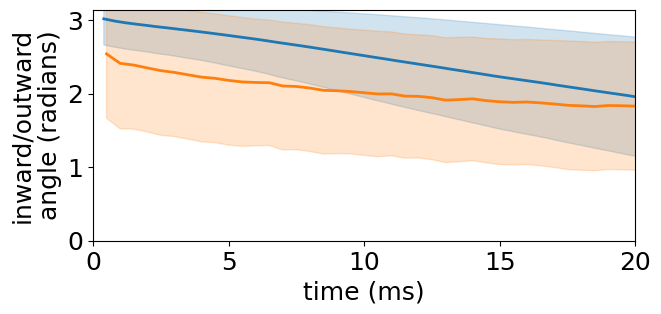

In [67]:
fontsize=18
fig,ax=plt.subplots(ncols=1,figsize=(7,3))#(5,4))
# axes=[1e-1,2,1e-3,0.2]
alpha=0.2
# FK
ax.fill_between(x_values_fk, y_values_fk-yerr_values_fk, y_values_fk+yerr_values_fk,color='C0',alpha=alpha)
ax.plot(x_values_fk,y_values_fk,'C0',lw=2)
#LR
ax.fill_between(x_values_lr, y_values_lr-yerr_values_lr, y_values_lr+yerr_values_lr,color='C1',alpha=alpha)
ax.plot(x_values_lr,y_values_lr,'C1',lw=2)

#TODO: add cuts for times



ax.set_xlim([0,20])#-DT])
# ax.set_xlim([-50,-DT])
ax.set_ylim([0,np.pi])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

#wrong bluf because aggregate
# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")
plt.show()

In [70]:
#plot the mean drdt versus r
#compute xy values
x_label='R (cm)'
y_label='dR/dt (cm/ms)'

df_fk.sort_values('tbirth',ascending=True,inplace=True)
df_lr.sort_values('tbirth',ascending=True,inplace=True)

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
t_values=dfm.index.values
range_values=dfm.r.values
drdt_values=np.diff(range_values)/DT
r_values=range_values[1:]/2+range_values[:-1]/2
x_values_lr=r_values
y_values_lr=drdt_values
# yerr_values_lr=dfs.theta.values

#fit drdt_values to F0+F1/r with OLS fit for LR model where 1/r is greater than some 1/cm
rmax=1.8 #cm
boo=r_values<rmax
x=1/r_values[boo]**2
y=drdt_values[boo]

# boo=y<0.4
boo=y<0.4
x_lr=x[boo]
y_lr=y[boo]

dict_force_fit=compute_95CI_ols(x_lr,y_lr)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values**2

x_lr=x.copy()
y_lr=y.copy()

dict_force_fit_lr=dict_force_fit
y_hat_values_lr=y_hat_values

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
t_values=dfm.index.values
range_values=dfm.r.values
drdt_values=np.diff(range_values)/DT
r_values=range_values[1:]/2+range_values[:-1]/2
x_values_fk=r_values
y_values_fk=drdt_values
# yerr_values_fk=dfs.theta.values

#fit drdt_values to F0+F1/r with OLS fit for FK model where 1/r is greater than 2 1/cm
rmax=.8#0.5 #cm
boo=r_values<rmax
x=1/r_values[boo]
y=drdt_values[boo]
dict_force_fit=compute_95CI_ols(x,y)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
dict_force_fit_fk=dict_force_fit
y_hat_values_fk=y_hat_values

print(f"the best fits are\n {dict_force_fit_lr} (LR) and \n{dict_force_fit_fk} (FK).")

the best fits are
 {'m': 0.007649030453349954, 'Delta_m': 0.013928840348237402, 'b': -0.0030468118356572825, 'Delta_b': 0.010217246058971131, 'Rsquared': 0.0018801935544889902} (LR) and 
{'m': 0.04284740300370185, 'Delta_m': 0.00040537812866687996, 'b': -0.02691653702650268, 'Delta_b': 0.0007756105478584457, 'Rsquared': 0.9994178343464858} (FK).


In [71]:
def print_dict(input_dict):
    for key in input_dict.keys():
        print(f"{key}={input_dict[key]}")

In [72]:
# #TODO: use better binning/averaging?  There are weird values popping up on the y axis...
# boo=y_lr<0.4
# plt.plot(x_lr[boo],y_lr[boo])
# plt.xscale('log')
# plt.yscale('log')
# print(compute_95CI_ols(np.log(x_lr[boo]),np.log(y_lr[boo])))
# plt.show()
# {'m': 1.1150177782249635, 'Delta_m': 0.0352362804512445, 'b': -3.5472307622899737, 'Delta_b': 0.03130914035225103, 'Rsquared': 0.9632068040661317}

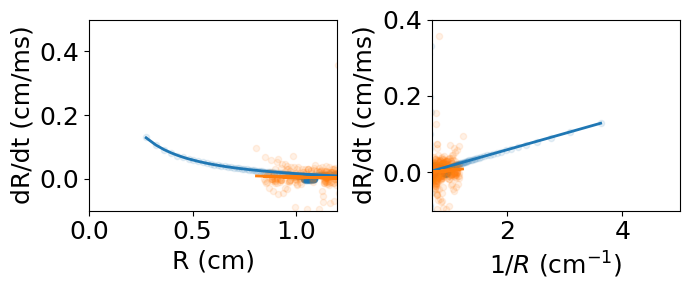

In [73]:
fontsize=18
alpha=0.1

fig,axs=plt.subplots(ncols=2,figsize=(7,3))#(5,4))
ax=axs[0]
ax.scatter(x_values_fk,y_values_fk,c='C0',s=20,alpha=alpha)
ax.scatter(x_values_lr,y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(x_values_fk,y_hat_values_fk,c='C0',lw=2,alpha=1)
ax.plot(x_values_lr,y_hat_values_lr,c='C1',lw=2,alpha=1)

ax.set_xlim([0,1.2])
ax.set_ylim([-0.1,.5])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

ax=axs[1]
ax.scatter(1/x_values_fk,y_values_fk,c='C0',s=20,alpha=alpha)
ax.scatter(1/x_values_lr,y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(1/x_values_fk,y_hat_values_fk,c='C0',lw=2,alpha=1)
ax.plot(1/x_values_lr,y_hat_values_lr,c='C1',lw=2,alpha=1)

# y_hat_values_fk
# y_hat_values_fk

ax.set_xlim([.7,5])
ax.set_ylim([-0.1,.4])
ax.set_xlabel(r'$1/R$ (cm$^{-1}$)',fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

For creation events from the LR model,
$$
F(R
)\propto\frac{dR}{dt} = b + \frac{m}{R}
$$


In [74]:
#TODO: try any more annihilation plots... 
# HINT: any from the following 3 panel
# HINT: are phi values present/convenient? Yes.
#TODO: condense the figures we like into functions. test on FK model
#TODO: make comparable functions for LR model. 
print(f"the ols fit for FK:")
print_dict(dict_force_fit_fk)
print(f"\nthe ols fit for LR:")
print_dict(dict_force_fit_lr)

the ols fit for FK:
m=0.04284740300370185
Delta_m=0.00040537812866687996
b=-0.02691653702650268
Delta_b=0.0007756105478584457
Rsquared=0.9994178343464858

the ols fit for LR:
m=0.007649030453349954
Delta_m=0.013928840348237402
b=-0.0030468118356572825
Delta_b=0.010217246058971131
Rsquared=0.0018801935544889902


In [75]:
nobs=df_fk.groupby('tbirth').r.count().iloc[0]
print(f"nobs={nobs} (FK)")
nobs=df_lr.groupby('tbirth').r.count().iloc[0]
print(f"nobs={nobs} (LR)")

nobs=7866 (FK)
nobs=3853 (LR)


## scratchwerk

In [35]:
print("(FK):")
a=a_hat_FK_vlong
D=D_hat_FK#,wjr=wjr,interp=interp,ax=ax,
model_name='fk_pbc'#;c='C0'
# a=a_hat_LR;D=D_hat_LR#,wjr=wjr,interp=interp,ax=ax,
# model_name='lr_pbc'#;c='C1'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'


#set attraction coefficient to zero
a=0
    
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)


#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu

q_values_fk=q_values.copy()
what_values_fk=what_values.copy()

#TODO: initialize changing parameters
print(f"initializing parameters to:")
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")
a0=float(a); D0=float(D); r0=float(r); kappa0=float(kappa);rmse0=float(rmse)
# dict_fk=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

(FK):
initializing parameters to:
a=0, D=0.365238, r=0.1, kappa=500.0, rmse=nan


In [36]:
#CONFIRMED: setting a=0 causes interp to become nan
#NOTE: ^this is consistent with my prior observation of a weird jump at a=0
#TODO: dev function that returns interp (r,kappa,D) conditioned on a=0

In [37]:
# interp=

In [38]:
#TODO: get interp working using an earlier example with the perturbation
X=np.array([[r0,kappa0,a0,D0]])
yhat = interp(X)
print(yhat)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu
#TODO: get interp working using an earlier example
# comp_rmse_via_interp
#TODO: show interp works for a perturbation
#TODO: make an array of guesses for interp
#TODO: compute the rmse for each
#TODO: return the smallest such parameter setting

[[nan nan]]


In [39]:
interp(np.array([[r,kappa,a,D],[r,kappa,a,D]]).T)

ValueError: number of dimensions in xi does not match x

In [ ]:
#initialize repeatably
a=float(a0); D=float(D0); r=float(r0); kappa=float(kappa0); rmse0=float(rmse)

In [ ]:
def perform_perturbation_D(a,D,r,kappa,dx):
    D*=(1+dx)
    return a,D,r,kappa
def perform_perturbation_r(a,D,r,kappa,dx):
    r*=(1+dx)
    return a,D,r,kappa
def perform_perturbation_kappa(a,D,r,kappa,dx):
    kappa*=(1+dx)
    return a,D,r,kappa

In [ ]:
q_values.shape,w_values.shape

In [ ]:
#option A: the high level approach
#DONE: make map from scalar r perturbation to mse
def fun_r(dx,a,D,r,kappa,q_values,w_values,interp):
    #perturb one parameter by a factor of 1+dx 
    a,D,r,kappa=perform_perturbation_r(a,D,r,kappa,dx)
    args=a,D,q_values,w_values,interp
    #compute loss function
    x=r,kappa
    argsp=a,D,q_values,w_values,interp
    mse=comp_mse_via_interp(x, *argsp)
    return mse

In [ ]:
perform_perturbation_r(a,D,r,kappa,dx),perform_perturbation_r(a,D,r,kappa,dx+1)

In [ ]:
def comp_mse_via_interp_simple(r,kappa,a,D,q_values,w_values,interp):
    '''compute the mean squared error from the xy values, q_values,w_values.
    the model uses the powerlaw fit returned by yhat = interp(np.array([[r,kappa,a,D]]))
    '''
    #interpolate nu and M using interp
    X=np.array([[r,kappa,a,D]])
    yhat = interp(X)
    nu=yhat[0,0]
    M=yhat[0,1]
    what_values=M*q_values**nu
    mse=np.mean((what_values-w_values)**2)
    return mse


In [ ]:
r,kappa,a,D,q_values,w_values,interp

In [ ]:
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu
mse=np.mean((what_values-w_values)**2)

In [ ]:
comp_mse_via_interp_simple(r,kappa,a,D,q_values,w_values,interp)

In [ ]:
#     a,D,r,kappa=perform_perturbation_r(a,D,r,kappa,dx)
#     args=a,D,q_values,w_values,interp
#compute loss function
x=r,kappa
argsp=a,D,q_values,w_values,interp
mse=comp_mse_via_interp(x, *argsp)
mse

In [ ]:
dx=1
fun_r(dx,a,D,r,kappa,q_values,w_values,interp)

In [ ]:
# can i iterate on an object of class returned by minimize?
# minimize?
trgt_parameter='r'
args=a,D,q_values,w_values,interp
fun=comp_fun_1D(res,args,trgt_parameter)
res_next=minimize_scalar(
    fun,
    bracket=None,
    bounds=None,
    args=args,
    method='brent',
    tol=None,
    options=None,
)

In [ ]:
#TODO: optimize r wrt mse

In [ ]:

#TODO: repeat ^that for any other desired parameters
#TODO: wrap ^that into a function
#TODO: iterate over ^that function 100 times
#TODO: plot the result
#TODO: increase the number of samples
#TODO: plot the result
#TODO: if the result didn't change, document, share, and go to bed.

In [ ]:
#option B: the low level approach
#TODO: perturb r
#TODO: measure change
#TODO: accept or deny

In [ ]:
#TODO: dev map from dict_res to dict_res
#map dict_res to args and the first parameter to be varied, r
#map dict_res to args and the next parameter to be varied, kappa
#map dict_res to args and the next parameter to be varied, D
#TODO: test ^that
#TODO: simply try simple 1D optimization (bounded tho)
#TODO(|failing ^that): try each available method for 1D optimization

In [ ]:
# fun=comp_fun_1D(res,args,trgt_parameter)
res_next=minimize_scalar(
    fun,
    bracket=None,
    bounds=None,
    args=(),
    method='brent',
    tol=None,
    options=None,
)

In [ ]:
# model_name='fk_pbc'#;c='C0'
# #compute annihilation rates fit to the LR model
# nu_full=wjr[model_name]['m']
# M_full=wjr[model_name]['M']
# q_values=np.linspace(0,1,20)
# w_values=M_full*q_values**nu_full
# args=a,D,q_values,w_values,interp
res.x,args

In [ ]:
r,kappa=res.x
r

In [ ]:
a_next,D_next,r_next,kappa_next=perform_perturbation_r(a,D,r,kappa,dx)

In [ ]:
trgt_parameter='r'
def fun(dx):   
    a,D,r,kappa=perform_perturbation(a,D,r,kappa,trgt_parameter)
    #compute loss function
    x=r,kappa
    argsp=a,D,q_values,w_values,interp
    mse=comp_mse_via_interp(x, *argsp)
    rmse=np.sqrt(mse)
    return mse#rmse

In [ ]:

# # define local fun to minimize in one coordinate only
# def comp_fun_1D(res,args,trgt_parameter):
#     '''run maps dx to mean squared error where dx is a change to the trgt_parameter
#     trgt_parameter is in {'a','D','r','kappa'}
#     '''
#     r,kappa=res.x
#     a,D,q_values,w_values,interp=args
#     trgt_parameter=str(trgt_parameter)

#     def fun(dx):   
#         a,D,r,kappa=perform_perturbation(a,D,r,kappa,trgt_parameter)
#         #compute loss function
#         x=r,kappa
#         argsp=a,D,q_values,w_values,interp
#         mse=comp_mse_via_interp(x, *argsp)
#         rmse=np.sqrt(mse)
#         return mse#rmse
#     return fun

In [ ]:
# can i iterate on an object of class returned by minimize?
# minimize?
trgt_parameter='r'
args=a,D,q_values,w_values,interp
fun=comp_fun_1D(res,args,trgt_parameter)
res_next=minimize_scalar(
    fun,
    bracket=None,
    bounds=None,
    args=(),
    method='brent',
    tol=None,
    options=None,
)

In [ ]:
fun(res),rmse

In [ ]:
# from scipy.optimize import minimize_scalar
# # minimize_scalar?
# method : str or callable, optional
#     Type of solver.  Should be one of:

#         - 'Brent'     :ref:`(see here) <optimize.minimize_scalar-brent>`
#         - 'Bounded'   :ref:`(see here) <optimize.minimize_scalar-bounded>`
#         - 'Golden'    :ref:`(see here) <optimize.minimize_scalar-golden>`
#         - custom - a callable object (added in version 0.14.0), see below
        
# Using the *Bounded* method, we find a local minimum with specified
# bounds as:
def f(x):
    return (x - 2) * x * (x + 2)**2
res = minimize_scalar(f, bounds=(-3, -1), method='bounded')
res.x

In [ ]:
def f(x):

#DONT: make change in a changing parameter
#DONT: wrap ^that into a function that maps paramter_state,parameter_col_change,comp_priority to parameter_state (or somethign)

In [ ]:
#TODO: make a function that tries to change each parameter by a random amount once


In [ ]:
#TODO: iterate through and perform tyree-potts refinement n_iter times from the base case 
n_iter=10

In [ ]:
# q_values_lr=q_values.copy()
# what_values_lr=what_values.copy()
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (LR)")
# dict_lr=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

In [ ]:
#DONE: copy 2A data gen
#DONE: test that ^that doesn't work
#TODO(option A): make a really simple least squares optimizer based on my "tyree-potts" optimization (randomly change one parameter, and keep if mse lowers)
#TODO(option B): root cause analysis as to why it doesn't work
#HINT: i remember trying every option in the function minimize to no avail...
#TODO: copy 2A figure gen

In [ ]:
#TODO(later): retry every option of the multidimensional minimization black box... but when q_values and w_values are strictly positive (>0)
# print("(FK):")
# a=a_hat_FK_vlong
# a=0
# D=D_hat_FK#,wjr=wjr,interp=interp,ax=ax,
# model_name='fk_pbc'#;c='C0'
# # a=a_hat_LR;D=D_hat_LR#,wjr=wjr,interp=interp,ax=ax,
# # model_name='lr_pbc'#;c='C1'
# #compute annihilation rates fit to the LR model
# nu_full=wjr[model_name]['m']
# M_full=wjr[model_name]['M']
# q_values=np.linspace(0.01,20)
# w_values=M_full*q_values**nu_full

# if model_name=='lr_pbc':
#     model_name_string='Luo-Rudy'
# elif model_name=='fk_pbc':
#     model_name_string='Fenton-Karma'
# else:
#     model_name_string='??'

# #find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
# bnds = ((1e-3, 2), (1e2, 1e4))
# x0 = (0.1, 500)
# # res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
# mse=comp_mse_via_interp(res.x, *args)
# rmse=np.sqrt(mse)

# # #set attraction coefficient to zero
# # a=0

# #compute the resulting annihilation rates
# r=res.x[0]
# kappa=res.x[1]
# X=np.array([[r,kappa,a,D]])
# yhat = interp(X)
# nu=yhat[0,0]
# M=yhat[0,1]
# what_values=M*q_values**nu

# q_values_fk=q_values.copy()
# what_values_fk=what_values.copy()

# #TODO: initialize changing parameters
# print(f"initializing parameters to:")
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")
# a0=float(a); D0=float(D); r0=float(r); kappa0=float(kappa);
# dict_fk=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

# scratchwerk

In [ ]:

fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#fit the particle model to the luo-rudy model
dict_out_lr=PlotParticlModelAnnihilationRateFit(a=a_hat_LR,D=D_hat_LR,wjr=wjr,interp=interp,
    ax=ax,model_name='lr_pbc',c='C1')
#fit the particle model to the fenton-karma model
dict_out_fk=PlotParticlModelAnnihilationRateFit(a=a_hat_FK_vlong,D=D_hat_FK,wjr=wjr,interp=interp,
    ax=ax,model_name='fk_pbc',c='C0')
print(f"\ndict_out_fk:")
print_dict(dict_out_fk)
print(f"dict_out_lr:")
print_dict(dict_out_lr)

In [ ]:
#TODO(option A): keep it simple, stupid!
#TODO(option B): keep it in the function
#TODO: add options to change lines from dashed to dotted
#TODO: add option for yoffset
#TODO: add option for ylabel of fit

In [ ]:
fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#fit the particle model to the luo-rudy model
dict_out_lr=PlotParticlModelAnnihilationRateFit(a=0,D=D_hat_LR,wjr=wjr,interp=interp,
    ax=ax,model_name='lr_pbc',c='C1')
#fit the particle model to the fenton-karma model
dict_out_fk=PlotParticlModelAnnihilationRateFit(a=0,D=D_hat_FK,wjr=wjr,interp=interp,
    ax=ax,model_name='fk_pbc',c='C0')
print(f"\ndict_out_fk:")
print_dict(dict_out_fk)
print(f"dict_out_lr:")
print_dict(dict_out_lr)

In [ ]:
#TODO: fork PlotParticlModelAnnihilationRateFit into PlotParticlModelAnnihilationRateFitUnattractive and condition it on a=0 explicitely
#HINT: it'll probably be easier if I 
#TODO: copy the whole PlotParticlModelAnnihilationRateFit
#TODO: run each block separately until I get to evidence that the fit didn't work
#...

In [ ]:
#recall ^these fits from lib
a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
print(f"a={a},    D={D}, r={r}, kappa={kappa},  rmse={rmse}")
a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")